In [1]:
# Plotting defaults (applied once per notebook)
from ama_tlbx.utils.plotting_config import DEFAULT_PLOT_CFG

DEFAULT_PLOT_CFG.apply_global()


# Correlation Analysis

Correlation analysis reveals relationships between features, identifies multicollinearity, and guides feature grouping for dimensionality reduction.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ama_tlbx.analysis import suggest_groups_from_correlation
from ama_tlbx.data import LECol, LifeExpectancyDataset
from ama_tlbx.plotting.correlation_plots import (
    plot_correlation_heatmap,
    plot_scatter_vs_target,
    plot_target_correlations,
    plot_top_correlated_pairs,
)
from IPython.display import display

np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["figure.labelsize"] = 11
plt.rcParams["figure.titleweight"] = "bold"


In [3]:
# le_ds = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
le_ds = LifeExpectancyDataset.from_csv(
    aggregate_by_country=2014,
    resolve_nand_pred="drop",
)


corr_result = le_ds.make_correlation_analyzer().fit().result()


## 1. Correlation Matrix Heatmap

Shows pairwise correlations between all numeric features.

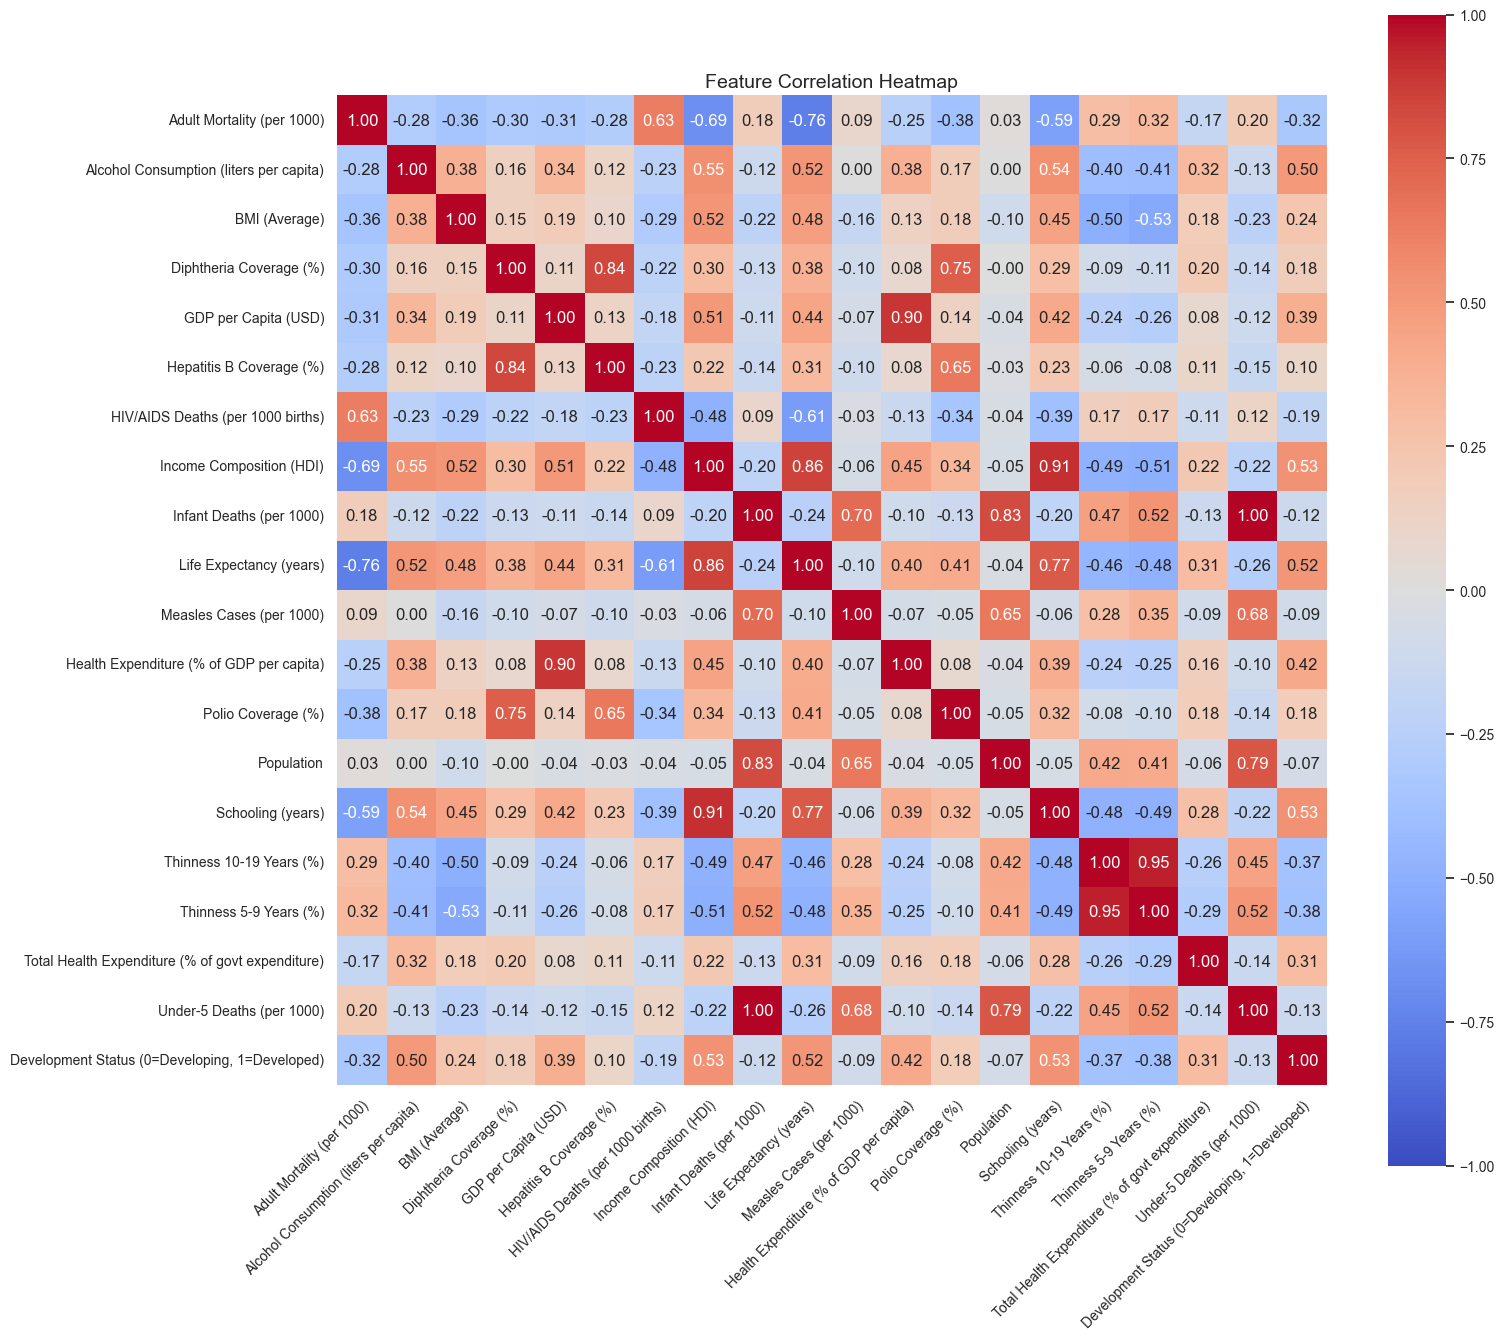

In [4]:
fig = corr_result.plot_heatmap(figsize=(16, 16))
plt.show()


## 2. Top Correlated Feature Pairs

Identifies the strongest positive and negative correlations for targeted analysis.

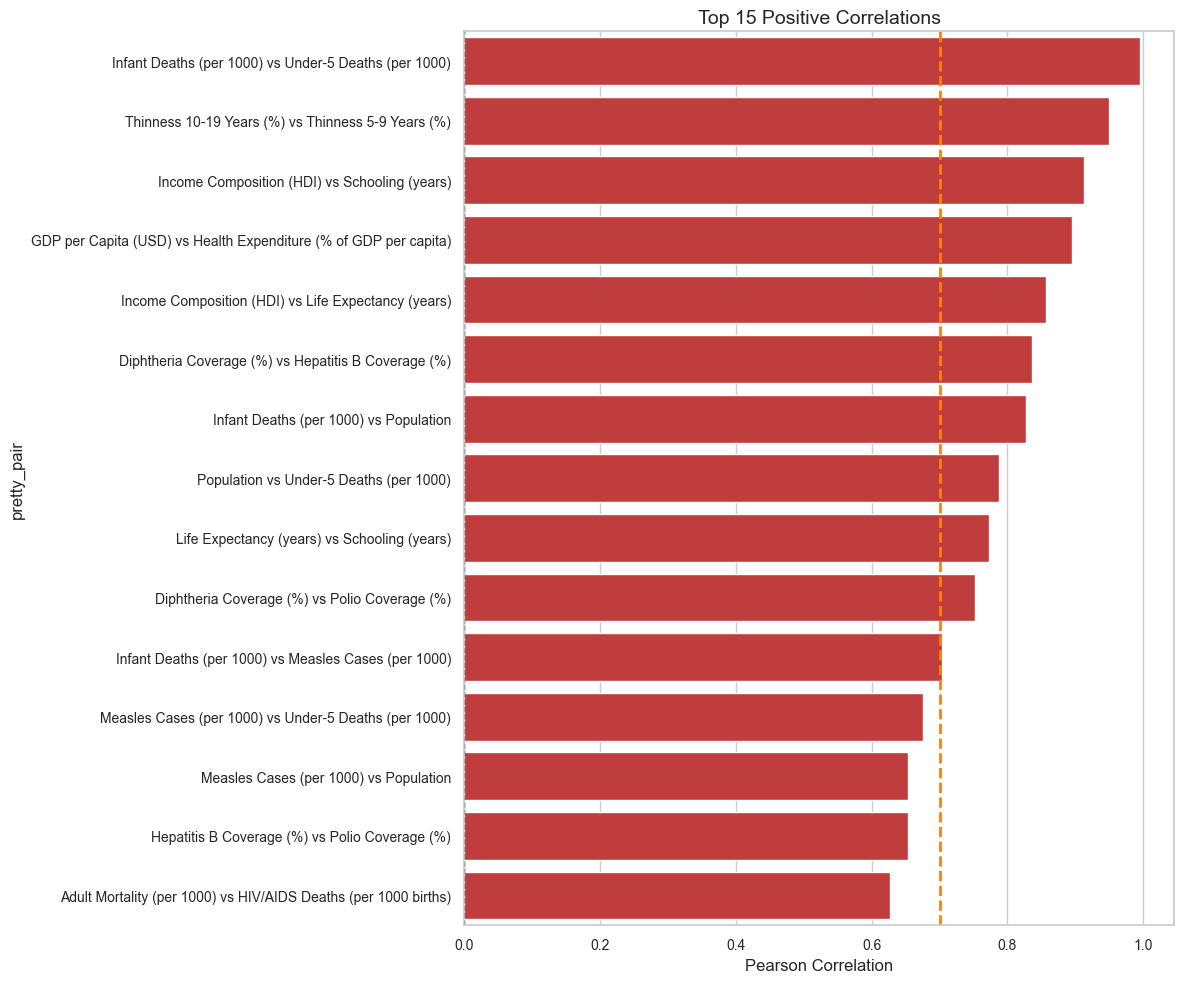

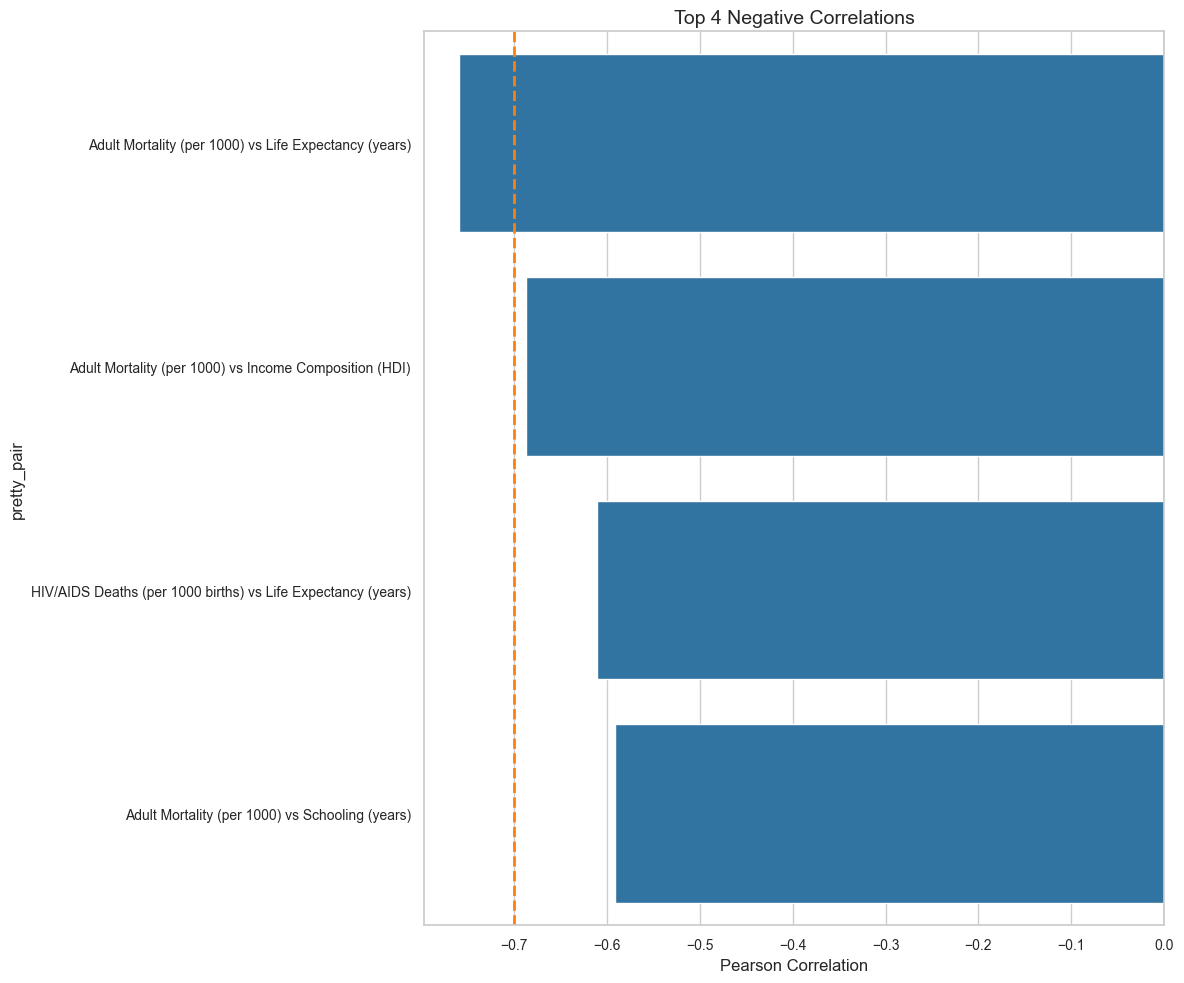

In [5]:
fig_pos, fig_neg = corr_result.plot_top_pairs(n=15, threshold=0.7)
plt.show()


## 3. Top Correlated Target Features

Identifies the strongest positive and negative correlations with the target variable.

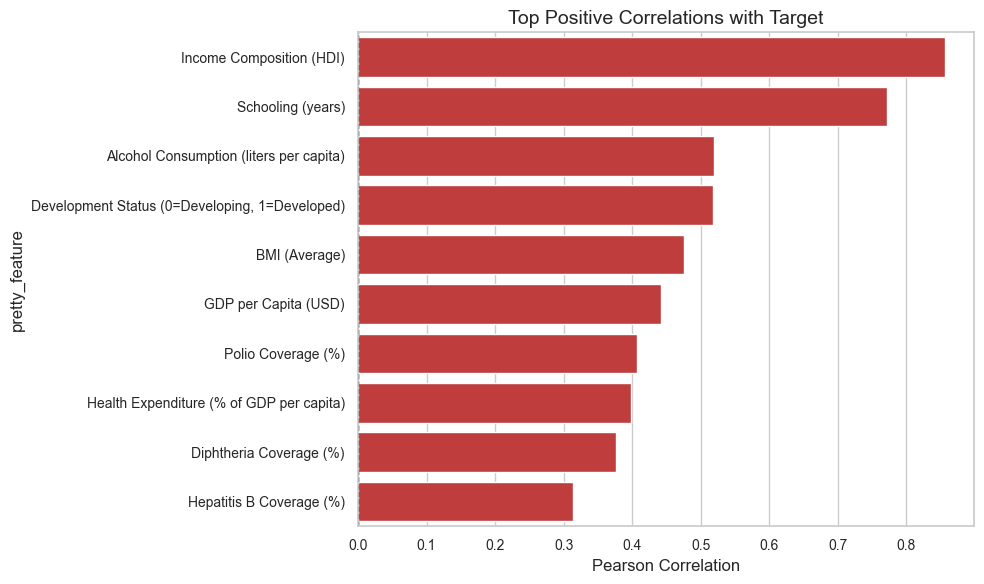

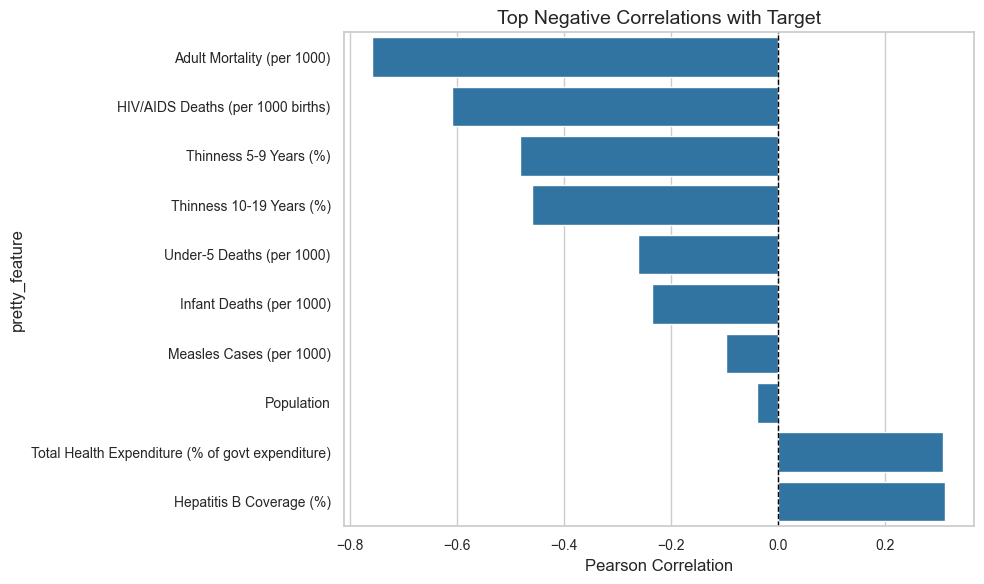

In [6]:
corr_result.plot_target_correlations()
plt.show()



## 3b. Effect of Transformations on Correlations

Compare the correlation structure before and after the default transforms (log/log1p and coverage inversion).
Delta = correlation(transformed) - correlation(raw); positive values mean the transform strengthened the linear relationship.


year  status  life_expectancy  \
country                                                             
Afghanistan                         2014       0             59.9   
Albania                             2014       0             77.5   
Algeria                             2014       0             75.4   
Angola                              2014       0             51.7   
Antigua and Barbuda                 2014       0             76.2   
...                                  ...     ...              ...   
Venezuela (Bolivarian Republic of)  2014       0             73.9   
Viet Nam                            2014       0             75.9   
Yemen                               2014       0             65.4   
Zambia                              2014       0             61.1   
Zimbabwe                            2014       0             59.2   

                                    adult_mortality  infant_deaths   alcohol  \
country                                                                        
Afghanistan                                1.156769       1.561200 -0.913216   
Albania                                   -1.330571      -1.033762  0.751248   
Algeria                                   -1.302198       0.887750 -0.913216   
Angola                                     1.885001       1.589248  1.267938   
Antigua and Barbuda                       -0.167290      -1.033762  1.291829   
...                                             ...            ...       ...   
Venezuela (Bolivarian Republic of)         0.088064       0.397614  1.049811   
Viet Nam                                  -0.195663       1.059480  0.673463   
Yemen                                      0.750094       1.227503 -0.913216   
Zambia                                     1.563444       1.059480 -0.913216   
Zimbabwe                                   2.102525       0.941840  1.053743   

                                    percentage_expenditure  hepatitis_b  \
country                                                                   
Afghanistan                                      -0.069459     1.294024   
Albania                                           0.576335    -1.133936   
Algeria                                          -0.179842    -0.477808   
Angola                                           -0.472550     1.244192   
Antigua and Barbuda                               1.213979    -1.517745   
...                                                    ...          ...   
Venezuela (Bolivarian Republic of)               -1.658475     0.794160   
Viet Nam                                         -1.658475    -0.477808   
Yemen                                            -1.658475     0.980364   
Zambia                                            0.290086     0.389545   
Zimbabwe                                         -0.748063     0.005735   

                                     measles       bmi  ...     polio  \
country                                                 ...             
Afghanistan                         0.989210 -1.071414  ...  1.464990   
Albania                            -1.009635  0.772315  ... -0.988526   
Algeria                            -1.009635  0.829633  ... -0.349806   
Angola                              2.010095 -0.875577  ...  1.221081   
Antigua and Barbuda                -1.009635  0.285112  ... -0.517812   
...                                      ...       ...  ...       ...   
Venezuela (Bolivarian Republic of) -1.009635  0.977705  ...  0.847454   
Viet Nam                            2.090921 -1.162168  ... -0.517812   
Yemen                               1.151652 -1.749677  ...  1.248590   
Zambia                             -0.267356 -0.870801  ...  0.888416   
Zimbabwe                           -1.009635 -0.464798  ...  0.023821   

                                    total_expenditure  diphtheria  hiv_aids  \
country                                                                       
Afghanistan  

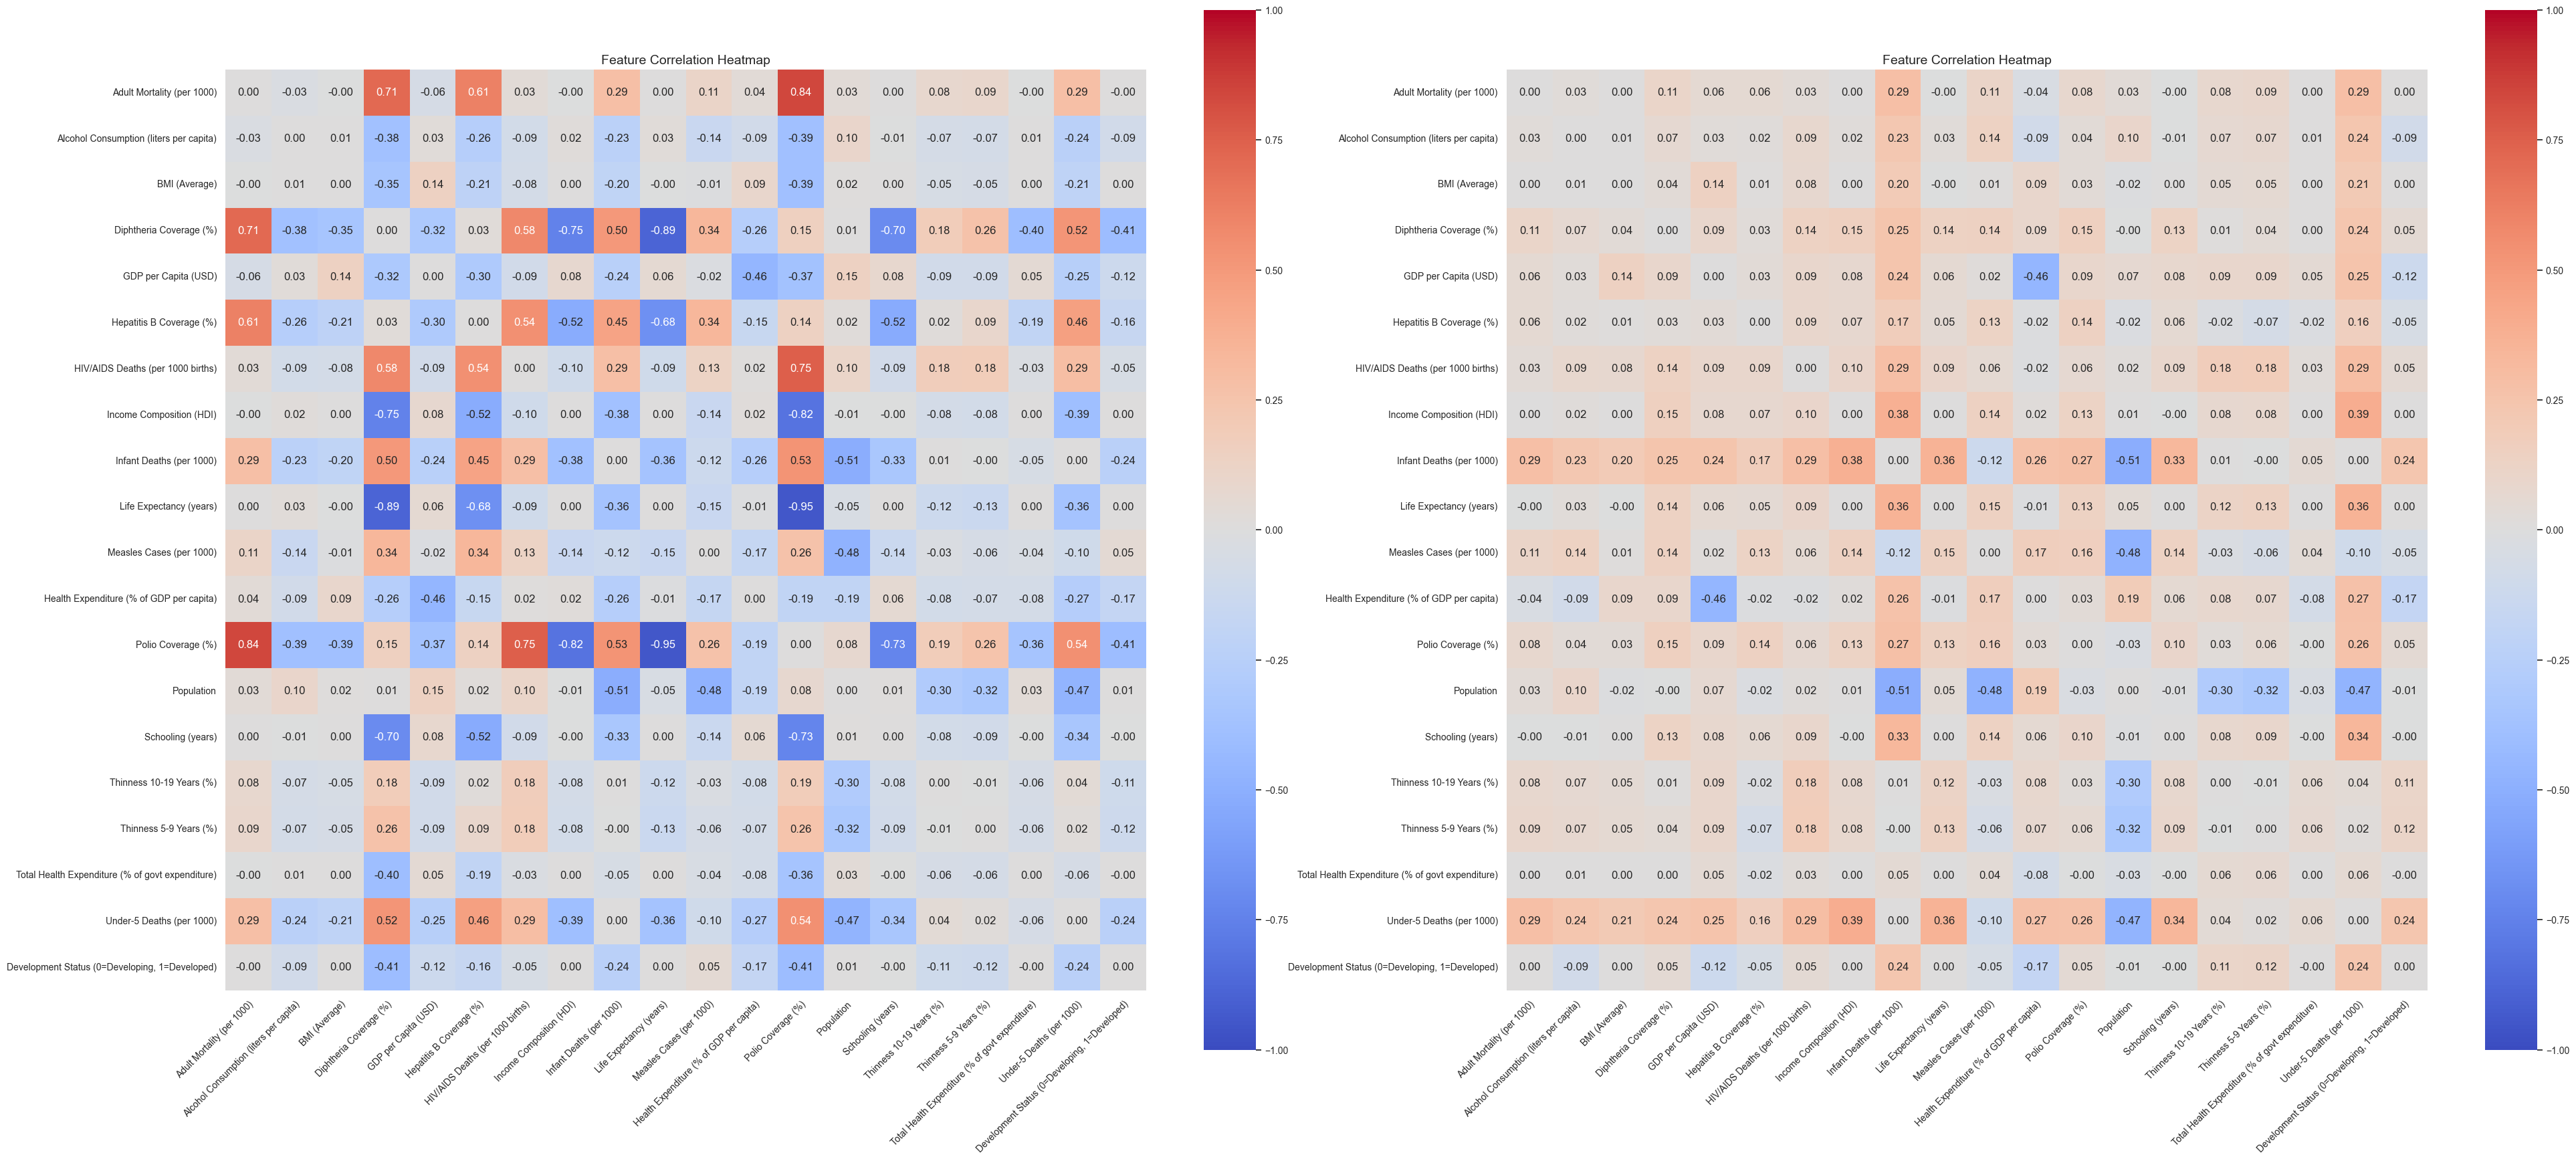

In [7]:
from ama_tlbx.analysis import CorrelationResult

tf_df = le_ds.tf_and_norm()
display(tf_df)

corr_result_tf = LifeExpectancyDataset(tf_df).make_correlation_analyzer().fit().result()

# Feature -> target deltas
base_tc = corr_result.target_correlations.set_index("feature")
tf_tc = corr_result_tf.target_correlations.set_index("feature")

delta_target = (
    tf_tc.rename(columns={"correlation": "corr_tf"})
    .join(base_tc.rename(columns={"correlation": "corr_raw"}))
    .assign(
        delta=lambda d: d.corr_tf - d.corr_raw,
        delta_abs=lambda d: d.corr_tf.abs() - d.corr_raw.abs(),
        pretty=lambda d: d.index.map(le_ds.get_pretty_name),
    )
    .assign(abs_delta=lambda d: d.delta.abs())
    .sort_values("abs_delta", ascending=False)
)


delta_result = CorrelationResult(
    matrix=corr_result_tf.matrix - corr_result.matrix,
    pretty_by_col=corr_result.pretty_by_col,
    feature_pairs=pd.DataFrame(),
)
delta_result_abs = CorrelationResult(
    matrix=corr_result_tf.matrix.abs() - corr_result.matrix.abs(),
    pretty_by_col=corr_result.pretty_by_col,
    feature_pairs=pd.DataFrame(),
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))
delta_corr = delta_result.matrix
delta_result.plot_heatmap(ax=ax1)
delta_result_abs.plot_heatmap(ax=ax2)
plt.show()


pretty  corr_raw  \
feature                                                                  
polio                                     Polio Coverage (%)  0.407273   
diphtheria                           Diphtheria Coverage (%)  0.375924   
hepatitis_b                         Hepatitis B Coverage (%)  0.313223   
infant_deaths                       Infant Deaths (per 1000) -0.235555   
under_five_deaths                  Under-5 Deaths (per 1000) -0.261950   
measles                             Measles Cases (per 1000) -0.096705   
thinness_5_9_years                    Thinness 5-9 Years (%) -0.483243   
thinness_1_19_years                 Thinness 10-19 Years (%) -0.459421   
hiv_aids                   HIV/AIDS Deaths (per 1000 births) -0.610431   
gdp                                     GDP per Capita (USD)  0.442067   
population                                        Population -0.040072   
alcohol              Alcohol Consumption (liters per capita)  0.519479   

                      corr_tf     delta  delta_abs  
feature                                             
polio               -0.540360 -0.947633   0.133086  
diphtheria          -0.511453 -0.887376   0.135529  
hepatitis_b         -0.363826 -0.677049   0.050604  
infant_deaths       -0.597198 -0.361643   0.361643  
under_five_deaths   -0.621516 -0.359565   0.359565  
measles             -0.243384 -0.146679   0.146679  
thinness_5_9_years  -0.616617 -0.133374   0.133374  
thinness_1_19_years -0.580075 -0.120654   0.120654  
hiv_aids            -0.705294 -0.094863   0.094863  
gdp                  0.503247  0.061180   0.061180  
population          -0.086919 -0.046847   0.046847  
alcohol              0.545584  0.026105   0.026105

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/2560381508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/2560381508.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


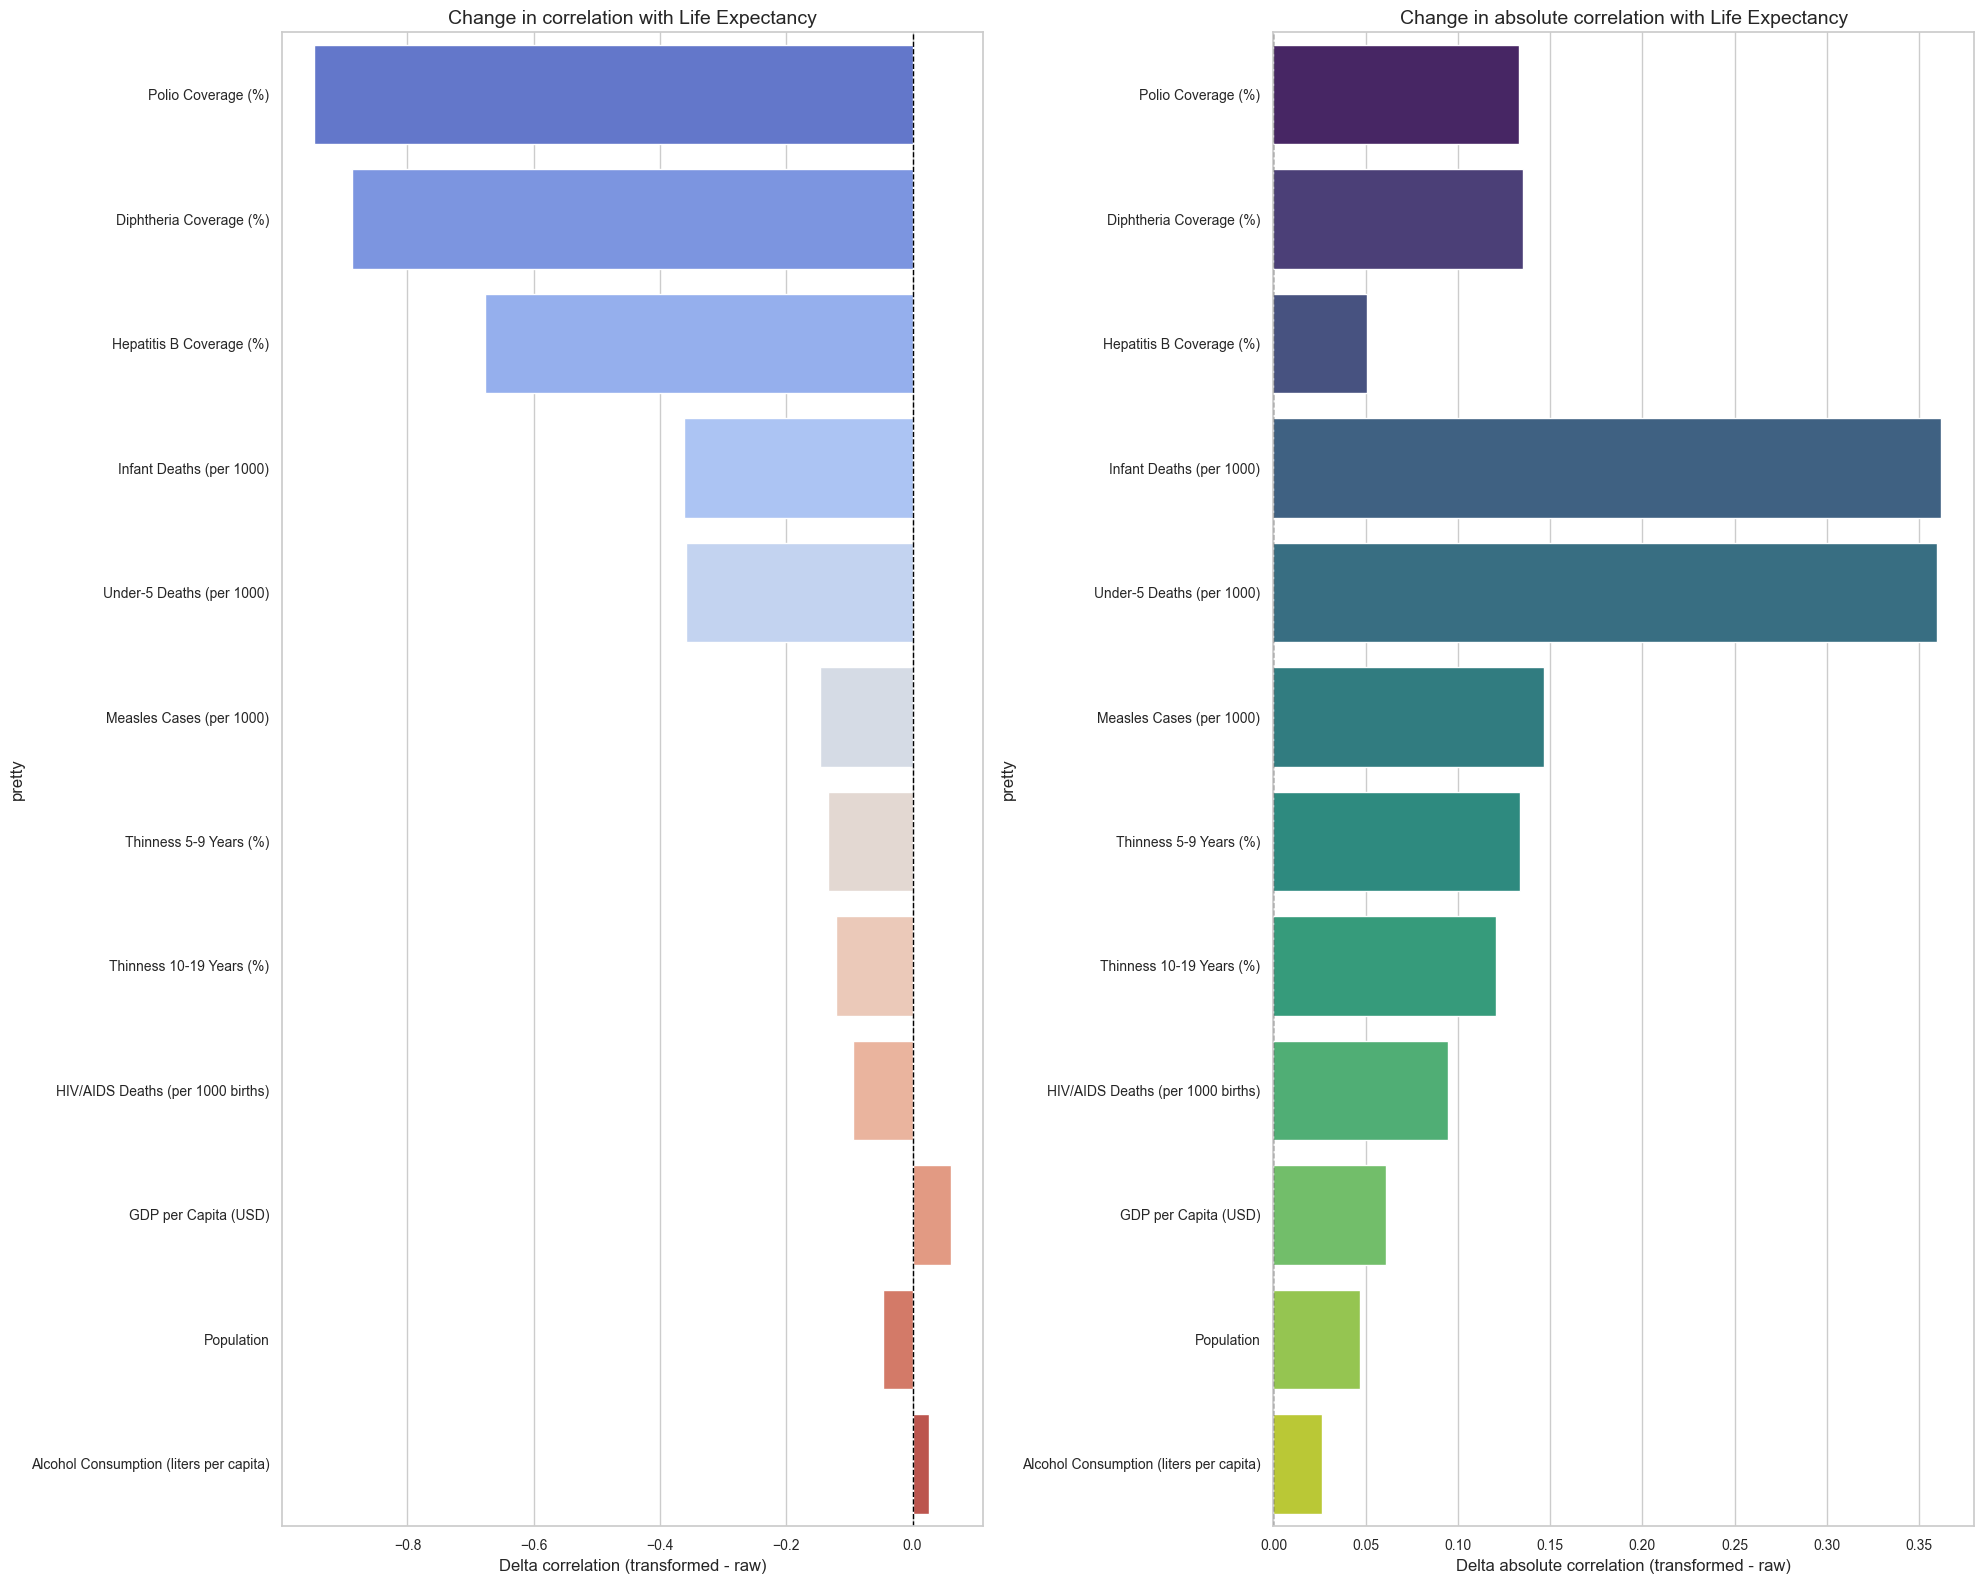

In [8]:
delta_target_top = delta_target[
    ["pretty", "corr_raw", "corr_tf", "delta", "delta_abs"]
].head(12)
display(delta_target_top)

# Visualize change in feature-target correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
sns.barplot(
    data=delta_target.reset_index().head(12),
    x="delta",
    y="pretty",
    palette="coolwarm",
    ax=ax1,
)
ax1.axvline(0, color="black", linestyle="--", linewidth=1)
ax1.set_title("Change in correlation with Life Expectancy")
ax1.set_xlabel("Delta correlation (transformed - raw)")
plt.tight_layout()

sns.barplot(
    data=delta_target.reset_index().head(12),
    x="delta_abs",
    y="pretty",
    palette="viridis",
    ax=ax2,
)
ax2.axvline(0, color="black", linestyle="--", linewidth=1)
ax2.set_title("Change in absolute correlation with Life Expectancy")
ax2.set_xlabel("Delta absolute correlation (transformed - raw)")
plt.tight_layout()
plt.show()


['adult_mortality', 'alcohol', 'bmi', 'diphtheria', 'gdp', 'hepatitis_b', 'hiv_aids', 'implied_health_exp', 'income_composition_of_resources', 'infant_deaths', 'measles', 'percentage_expenditure', 'polio', 'population', 'schooling', 'thinness_1_19_years', 'thinness_5_9_years', 'total_expenditure', 'under_five_deaths', <LifeExpectancyColumn.STATUS: 'status'>]


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

Skip implied_health_exp: "['implied_health_exp'] not in index"


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/1663500990.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

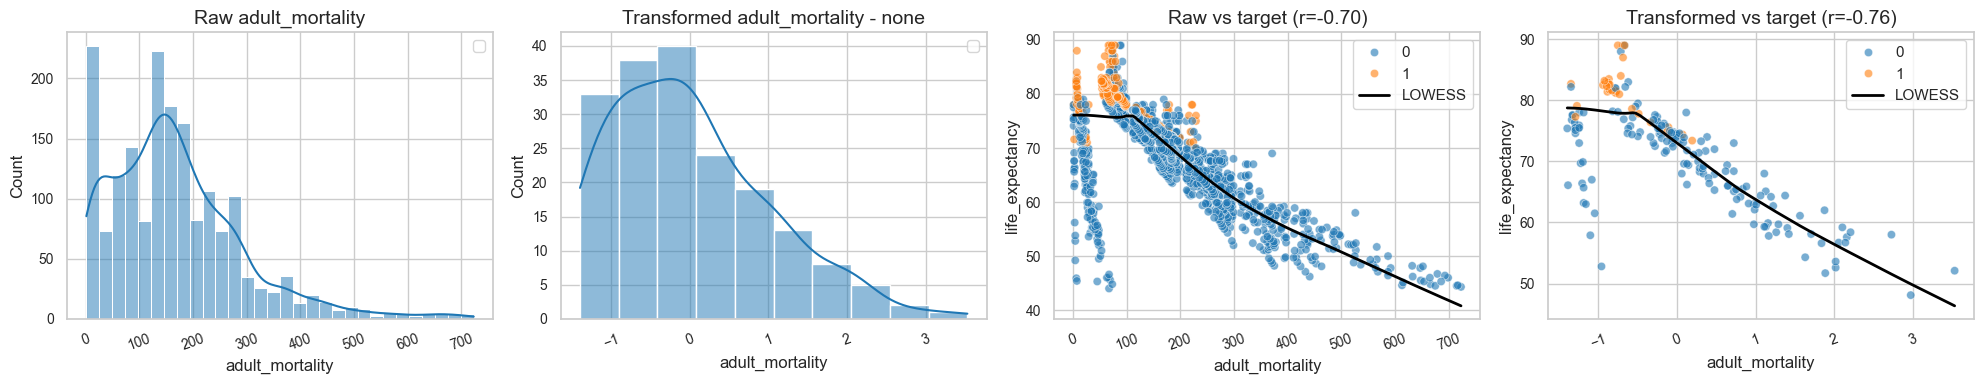

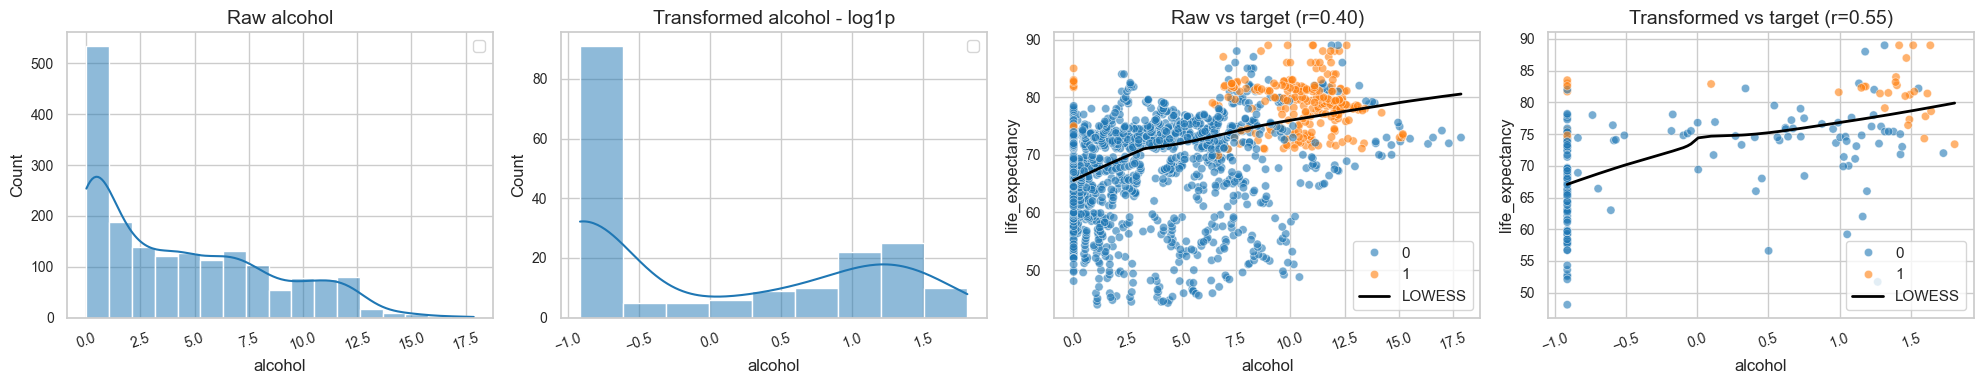

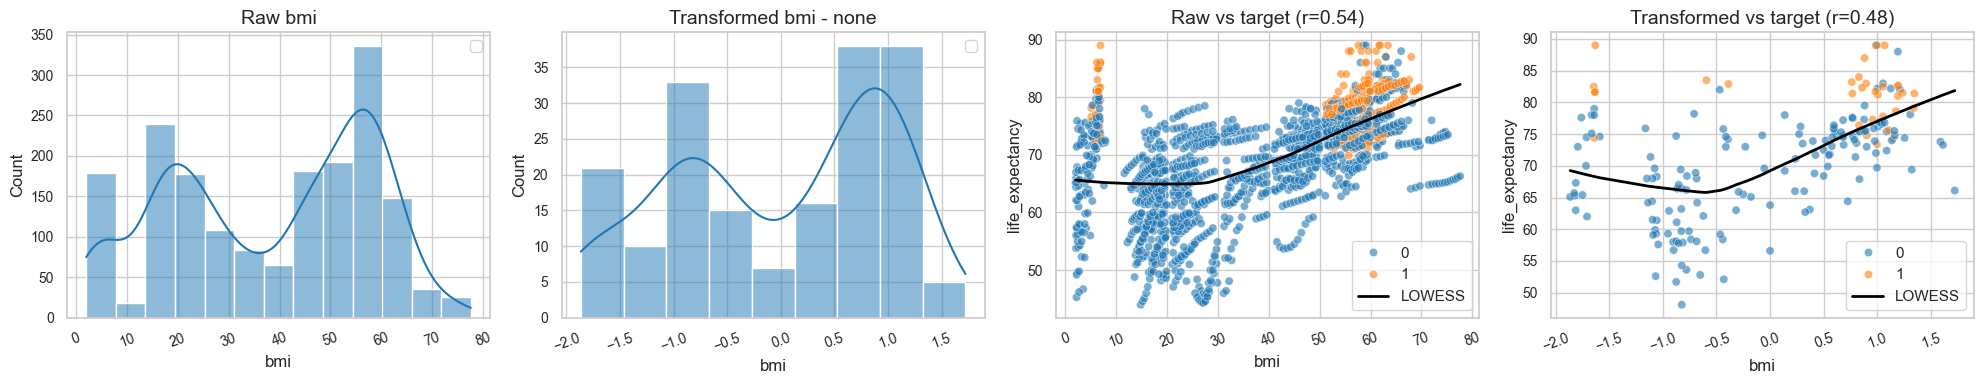

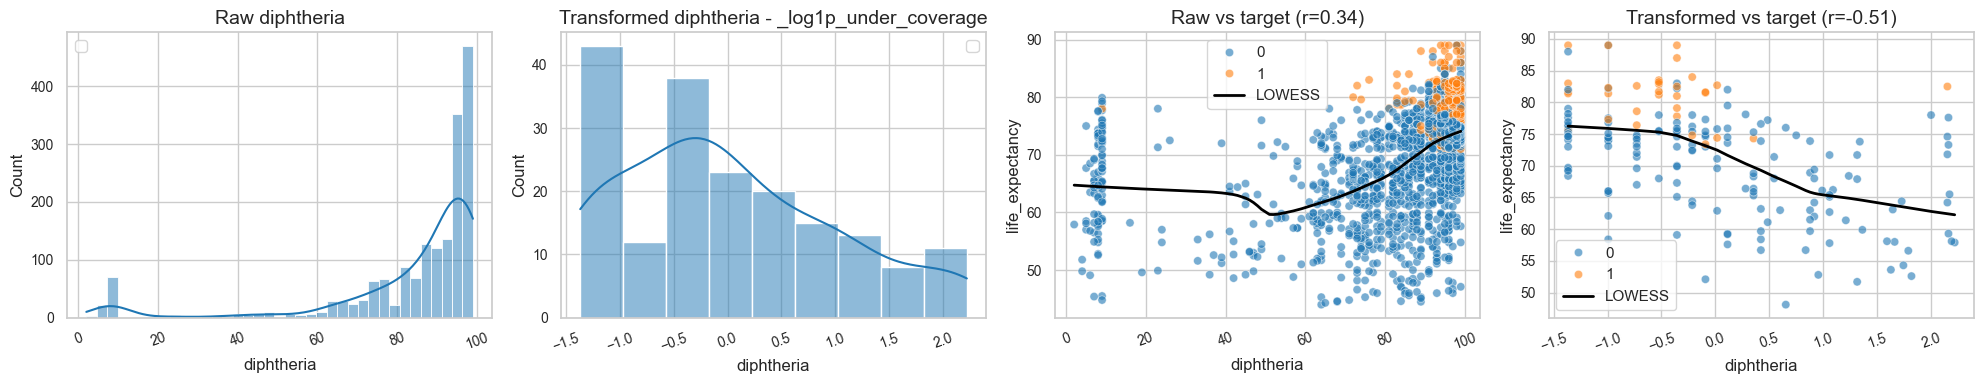

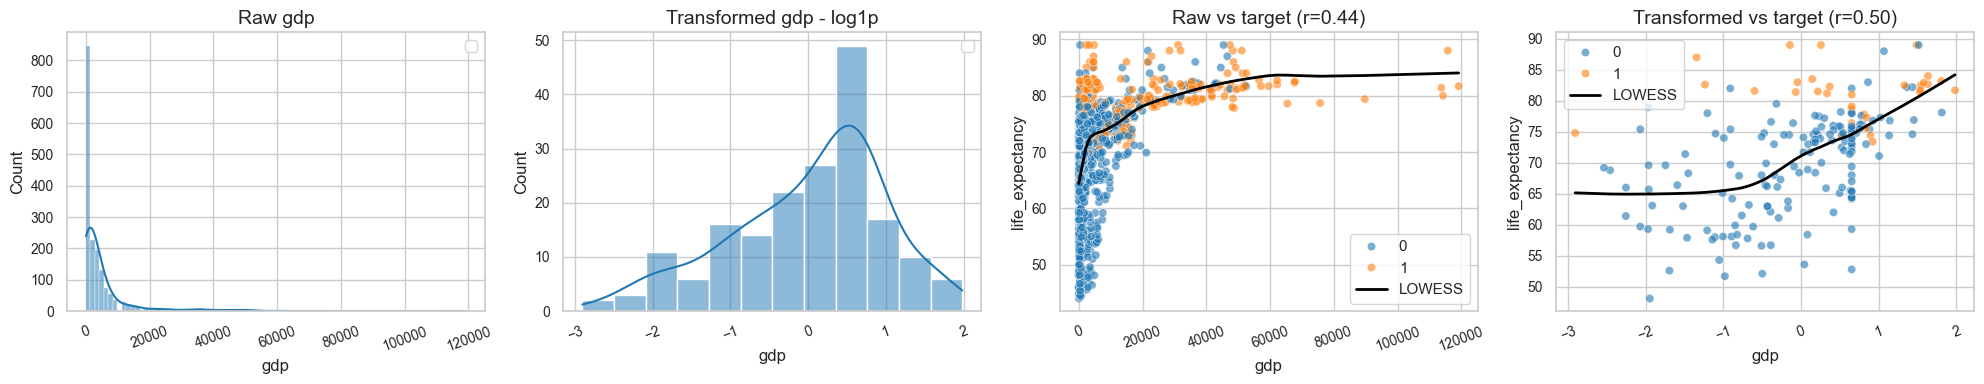

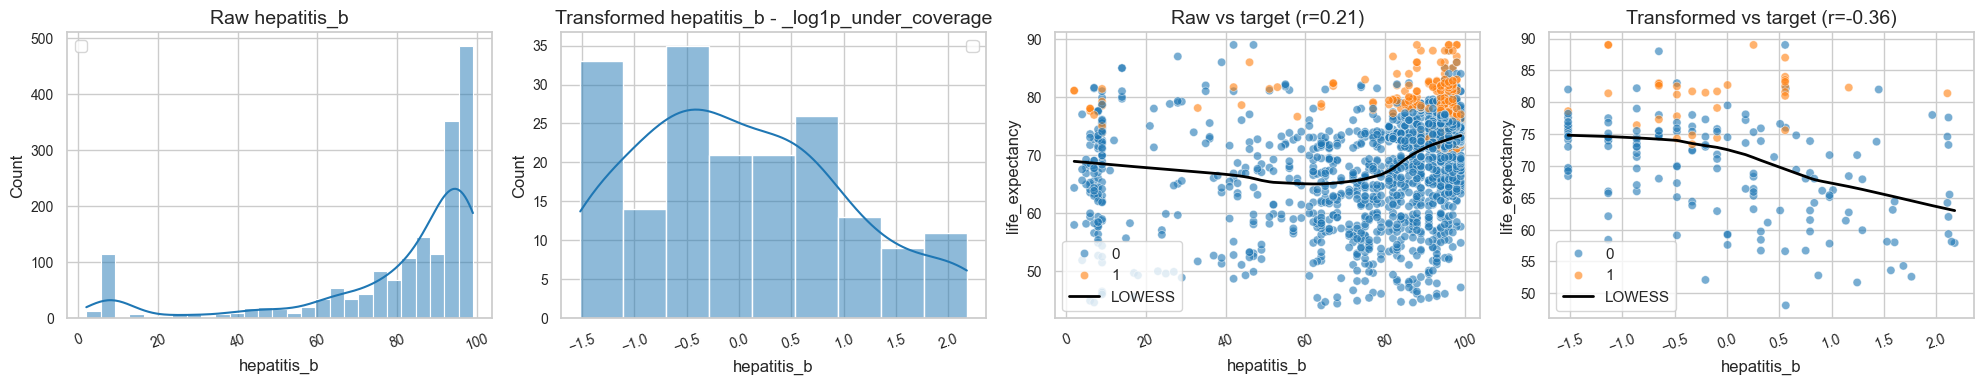

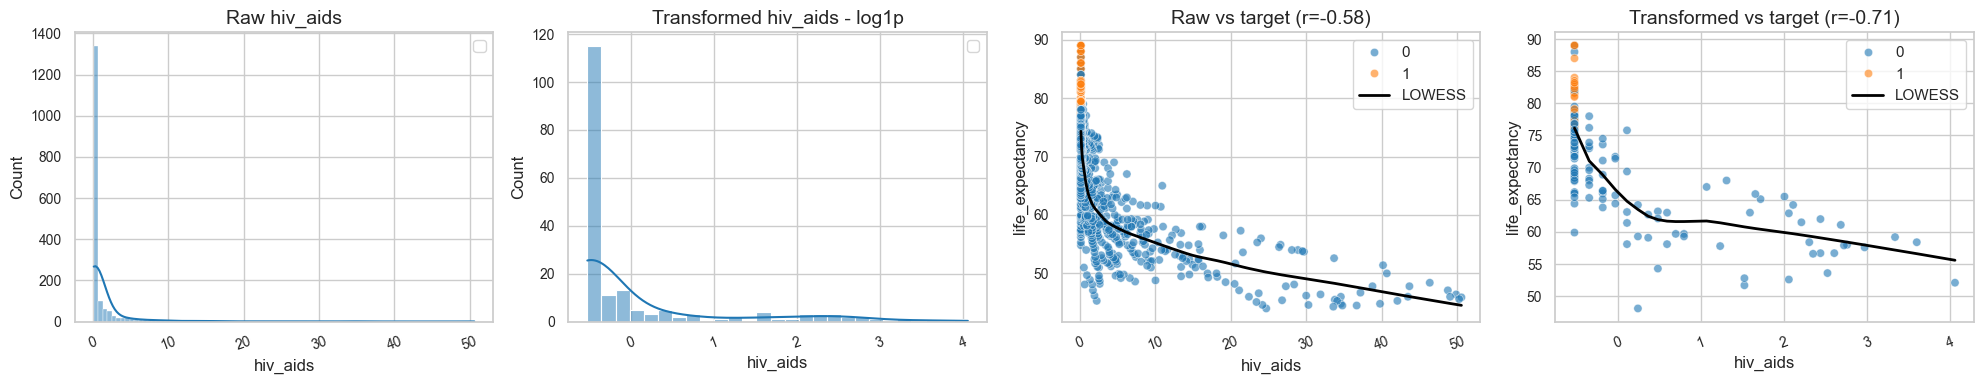

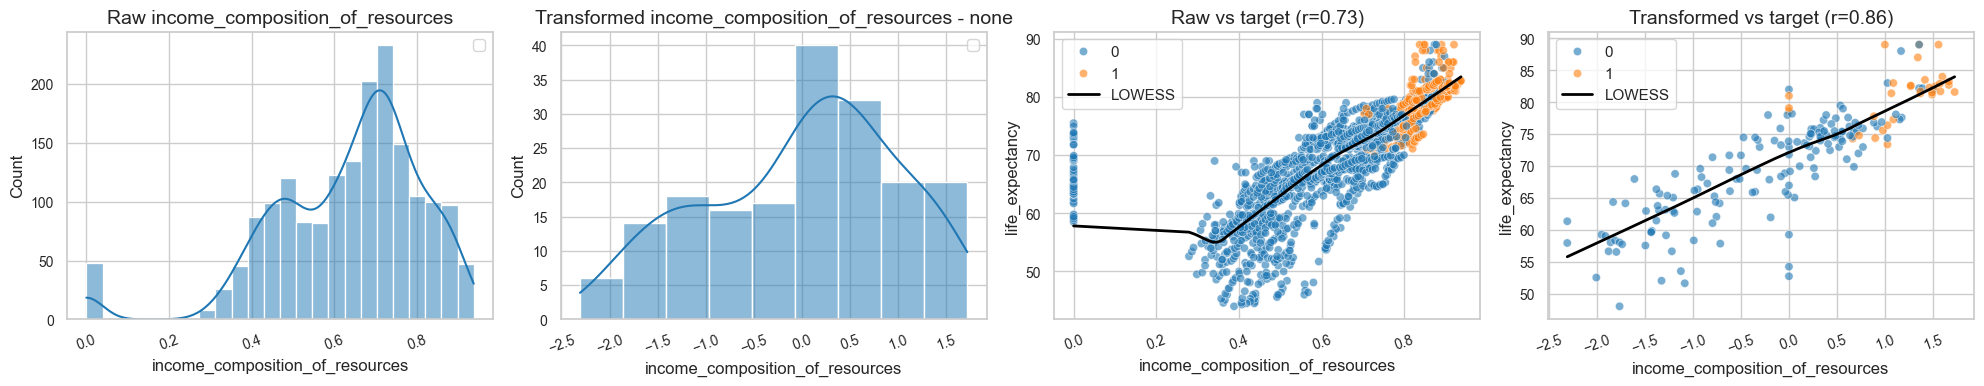

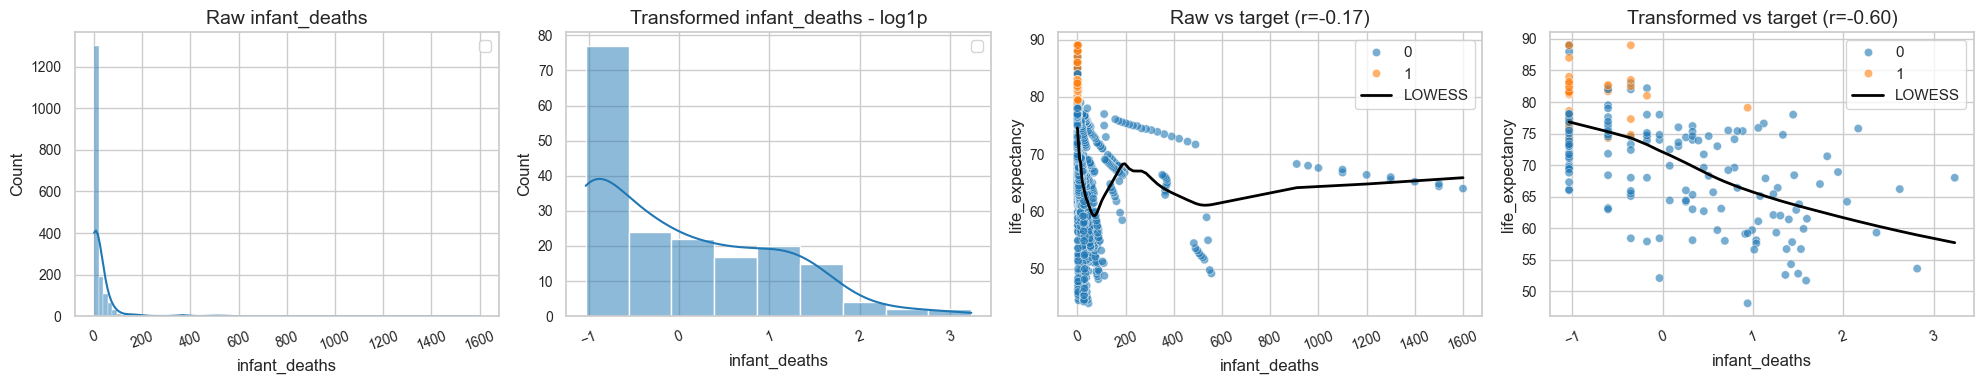

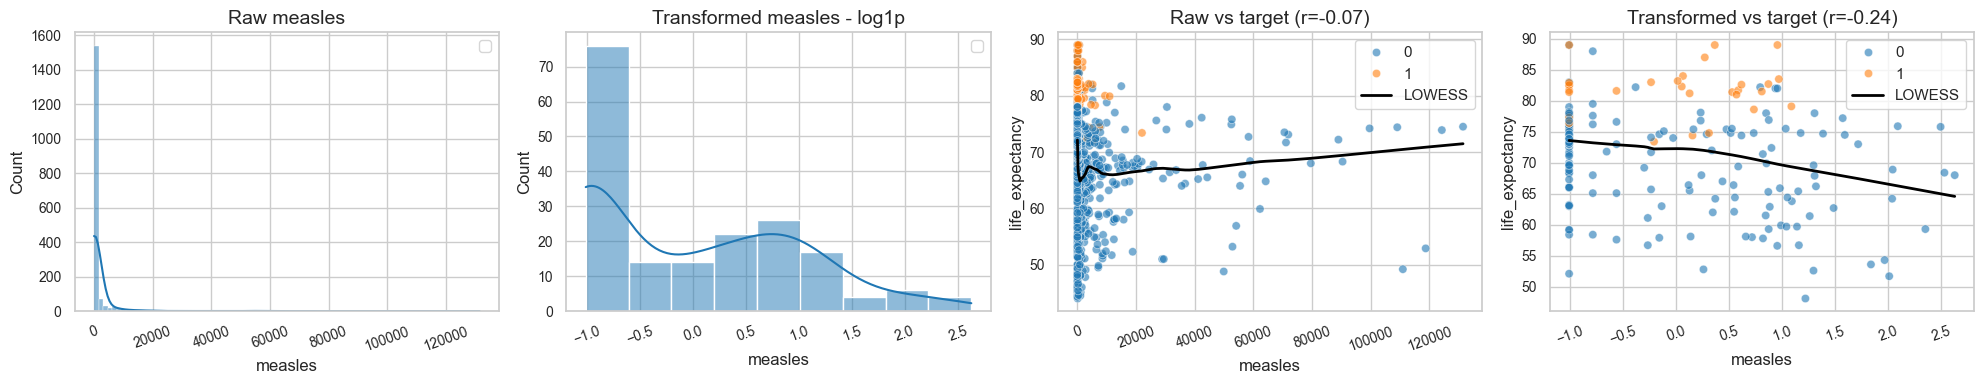

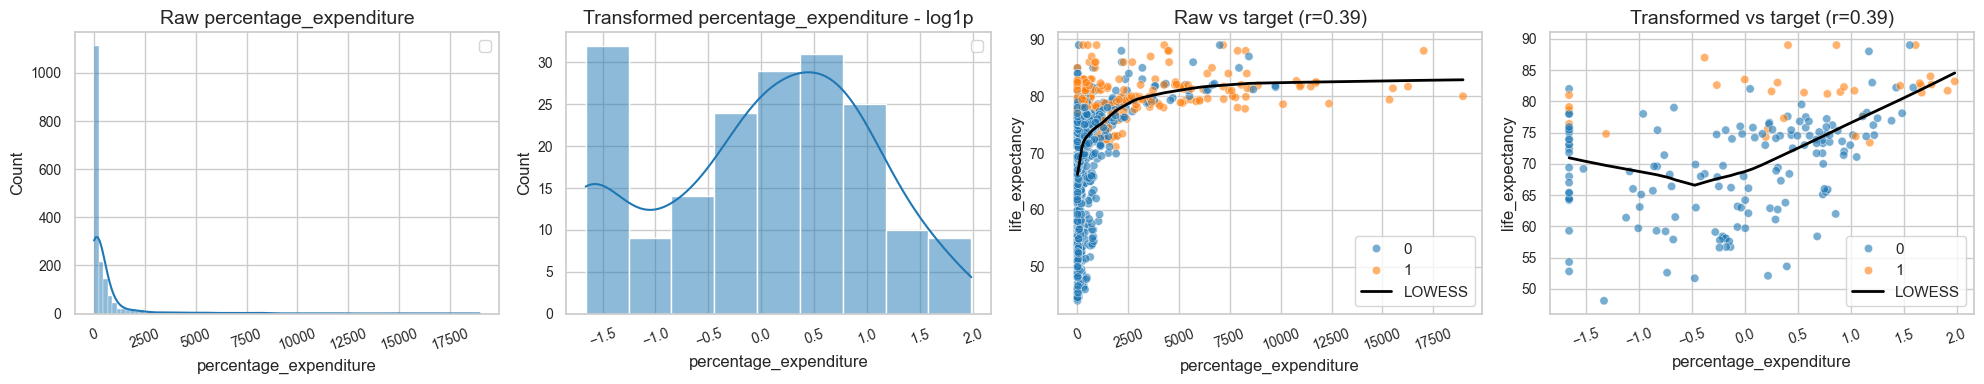

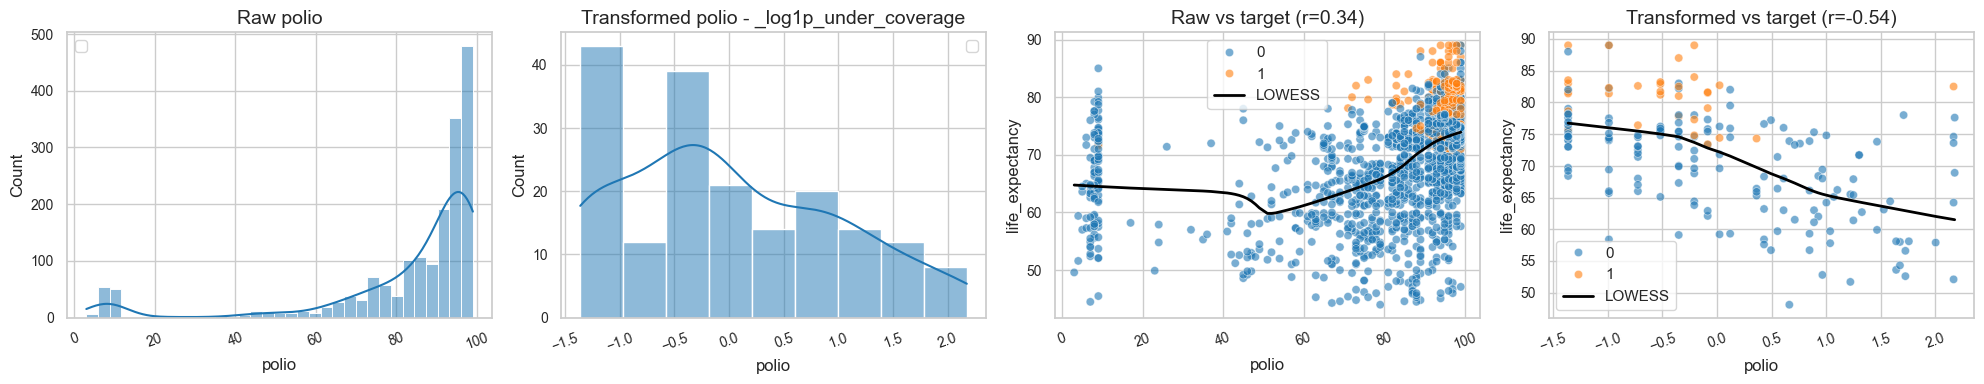

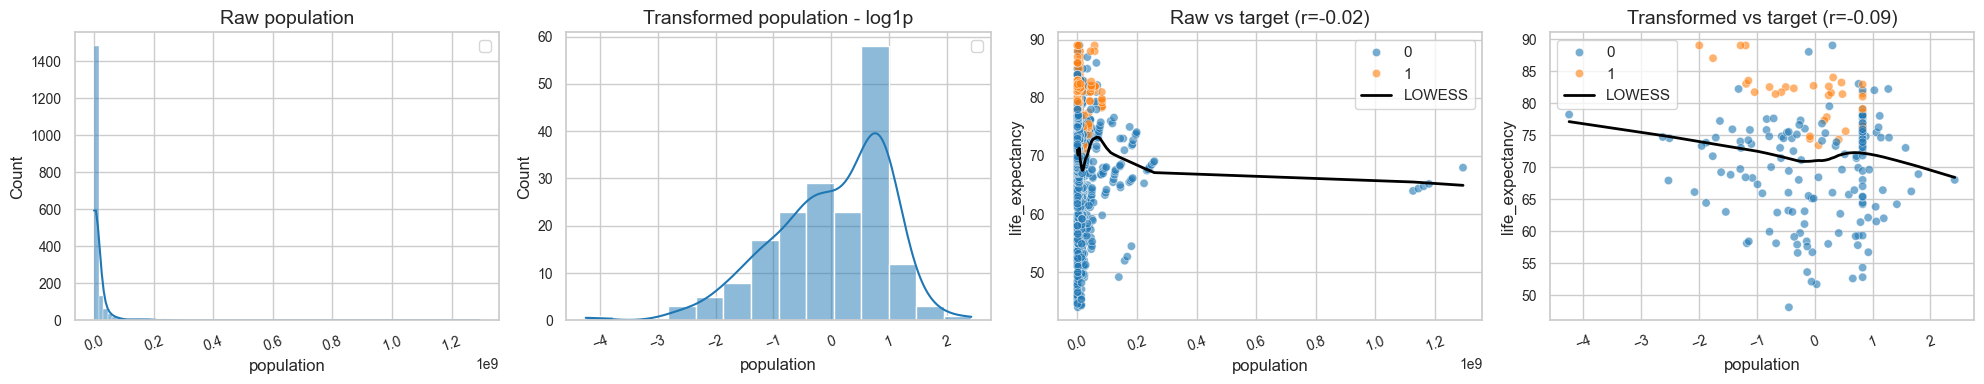

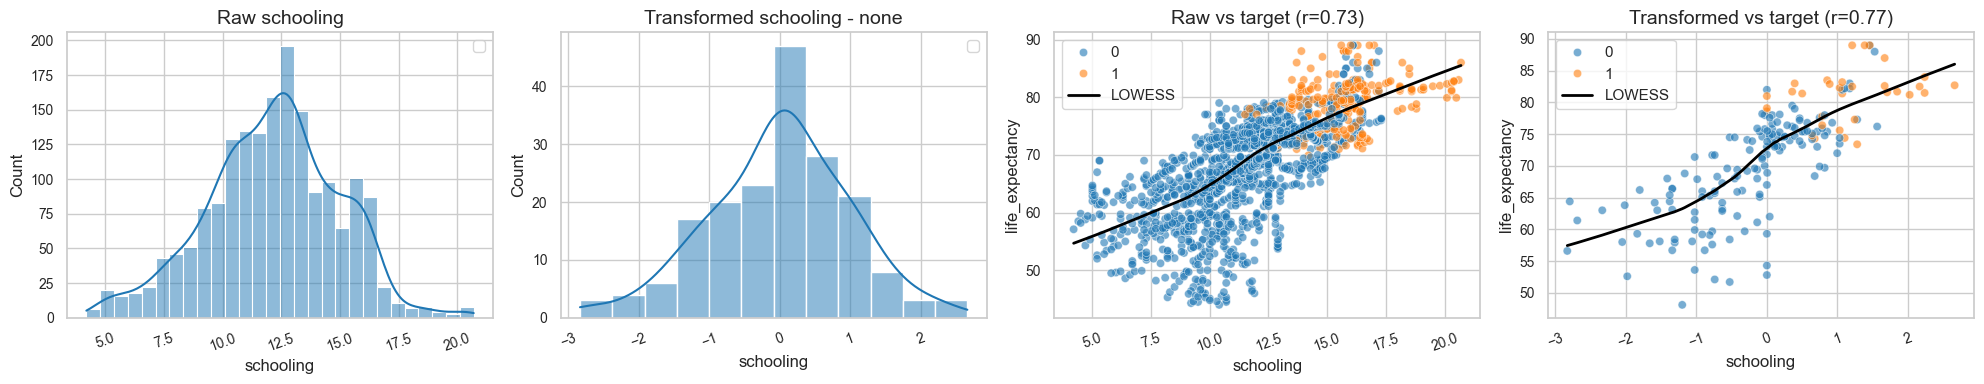

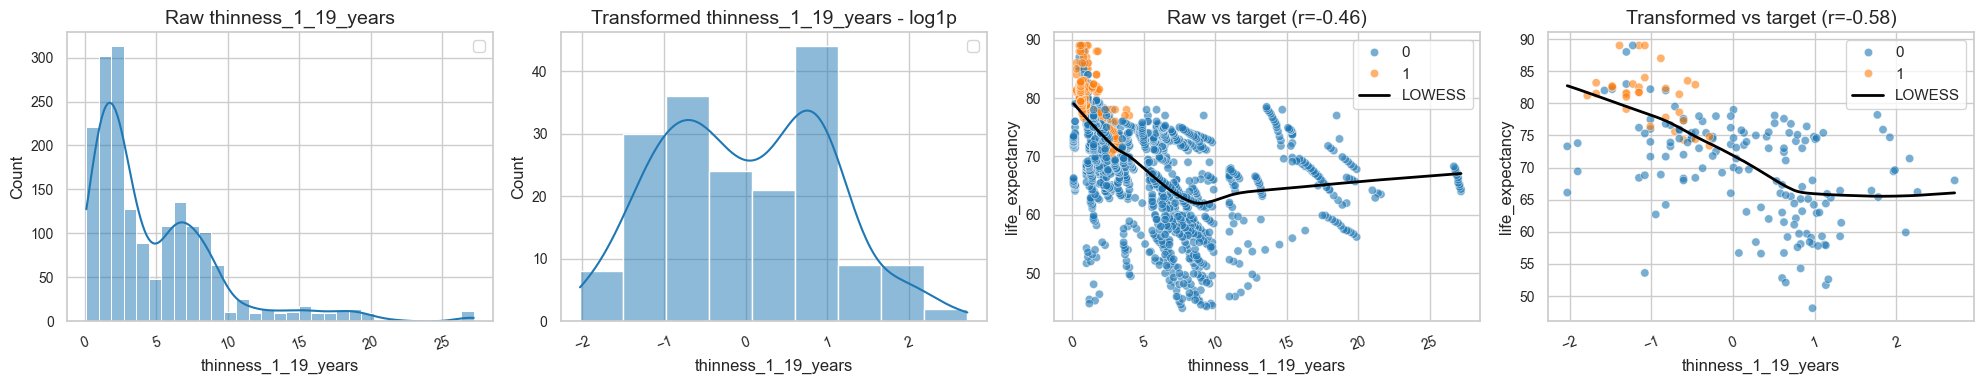

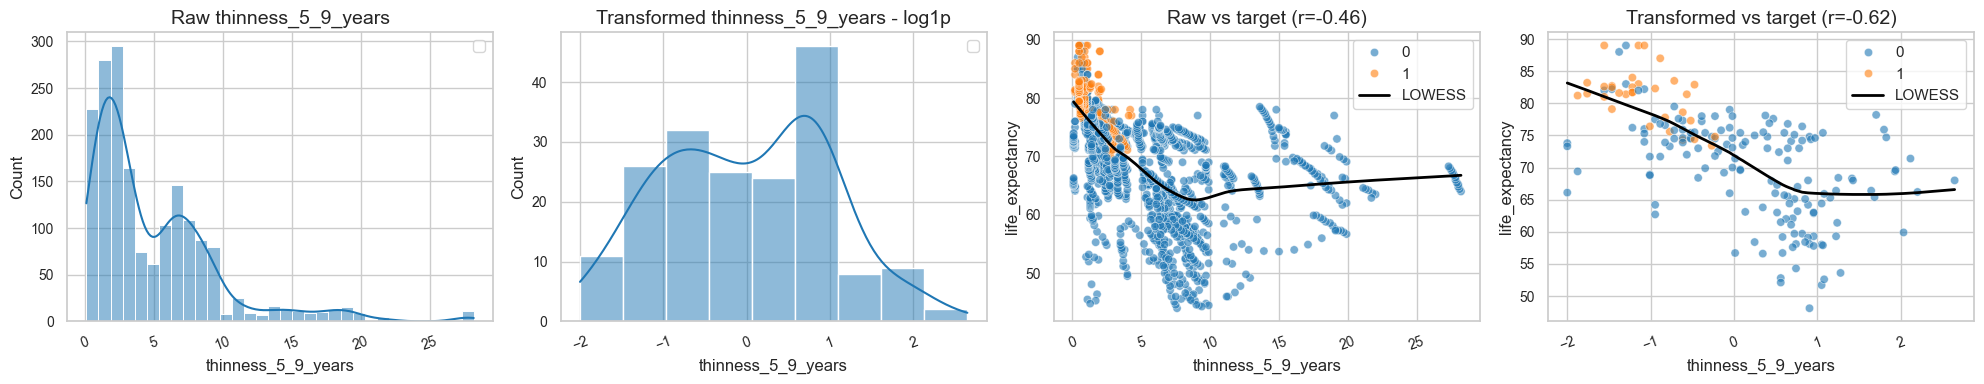

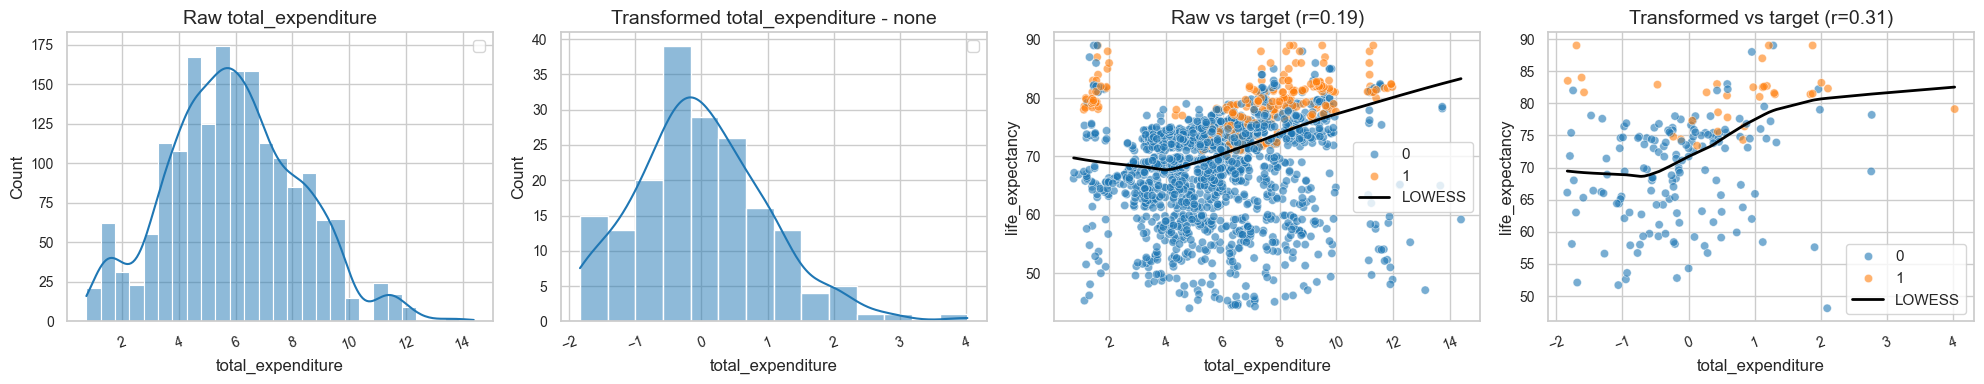

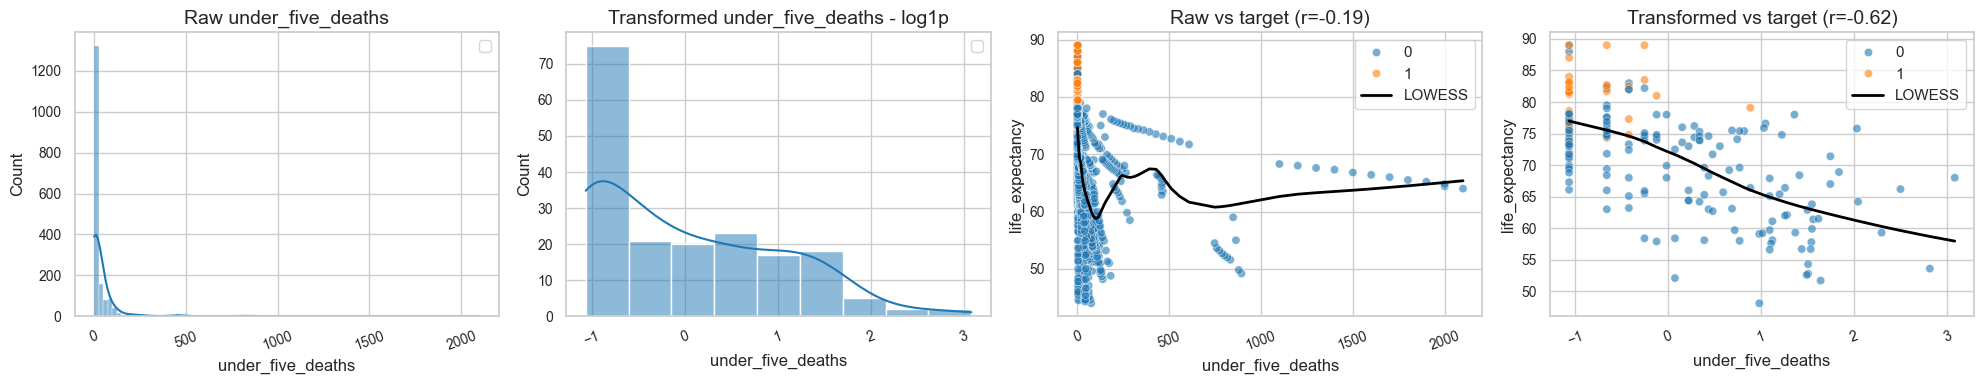

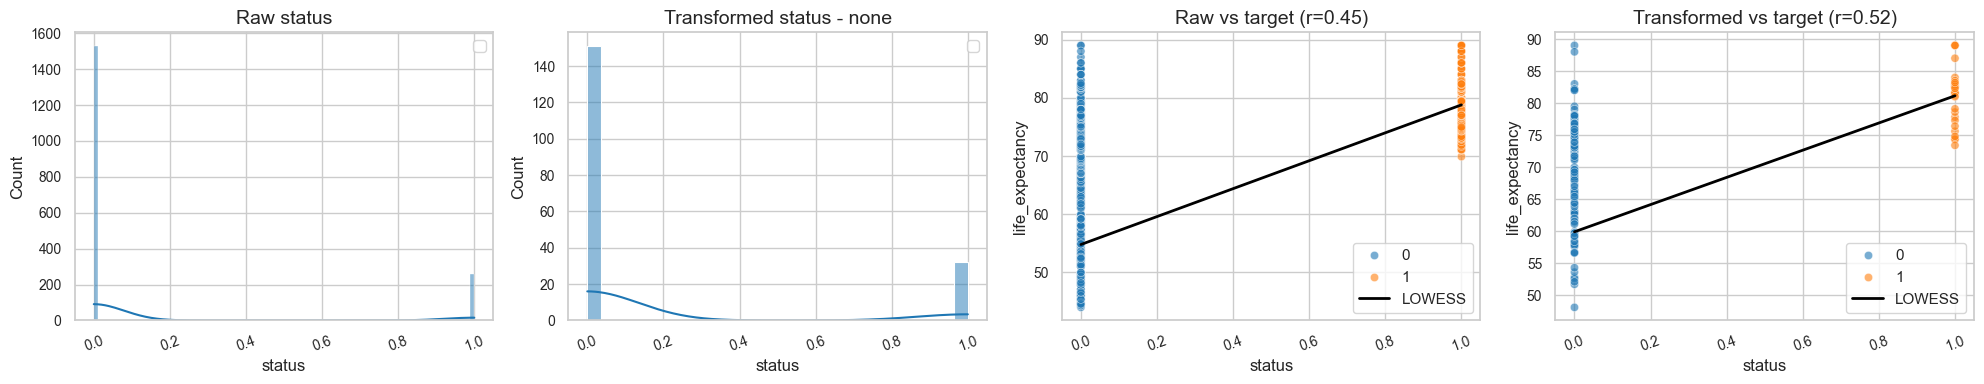

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def diagnose_transform(
    col: str,
    target: str = LECol.LIFE_EXPECTANCY,
    hue: str | None = LECol.STATUS,
    lowess_frac: float = 0.7,
):
    """Compare raw vs transformed distribution and target correlation for one feature.

    - Hue is applied to the scatter points only.
    - A single LOWESS line is drawn per panel (global fit), not per hue.
    """
    col = str(col)
    target = str(target)
    hue = str(hue) if hue else None

    cols = [col, target]
    if hue and hue not in cols:
        cols.append(hue)

    raw = le_ds.df[cols].dropna()
    tf = tf_df[cols].dropna()

    corr_raw = raw[col].corr(raw[target])
    corr_tf = tf[col].corr(tf[target])

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    sns.histplot(raw[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Raw {col}")

    sns.histplot(tf[col], kde=True, ax=axes[1])
    meta = LECol(col).metadata()
    transform = meta.transform
    if transform is None:
        transform_name = "none"
    else:
        transform_name = getattr(transform, "__name__", transform.__class__.__name__)
    axes[1].set_title(f"Transformed {col} - {transform_name}")

    # Scatter with hue; one global LOWESS per panel
    sns.scatterplot(data=raw, x=col, y=target, hue=hue, alpha=0.6, ax=axes[2])
    if len(raw) >= 8 and raw[col].nunique() > 1 and raw[target].nunique() > 1:
        smooth = lowess(raw[target], raw[col], frac=lowess_frac, return_sorted=True)
        axes[2].plot(
            smooth[:, 0],
            smooth[:, 1],
            color="black",
            linewidth=2,
            label="LOWESS",
        )
    axes[2].set_title(f"Raw vs target (r={corr_raw:.2f})")

    sns.scatterplot(data=tf, x=col, y=target, hue=hue, alpha=0.6, ax=axes[3])
    if len(tf) >= 8 and tf[col].nunique() > 1 and tf[target].nunique() > 1:
        smooth_tf = lowess(tf[target], tf[col], frac=lowess_frac, return_sorted=True)
        axes[3].plot(
            smooth_tf[:, 0],
            smooth_tf[:, 1],
            color="black",
            linewidth=2,
            label="LOWESS",
        )
    axes[3].set_title(f"Transformed vs target (r={corr_tf:.2f})")

    for ax in axes:
        ax.tick_params(axis="x", rotation=20)
        if hue:
            ax.legend()

    plt.tight_layout()
    return corr_raw, corr_tf


# Batch run example
auto_cols = le_ds.feature_columns()
print(auto_cols)
for col in auto_cols:
    try:
        diagnose_transform(col)
    except Exception as e:
        print(f"Skip {col}: {e}")


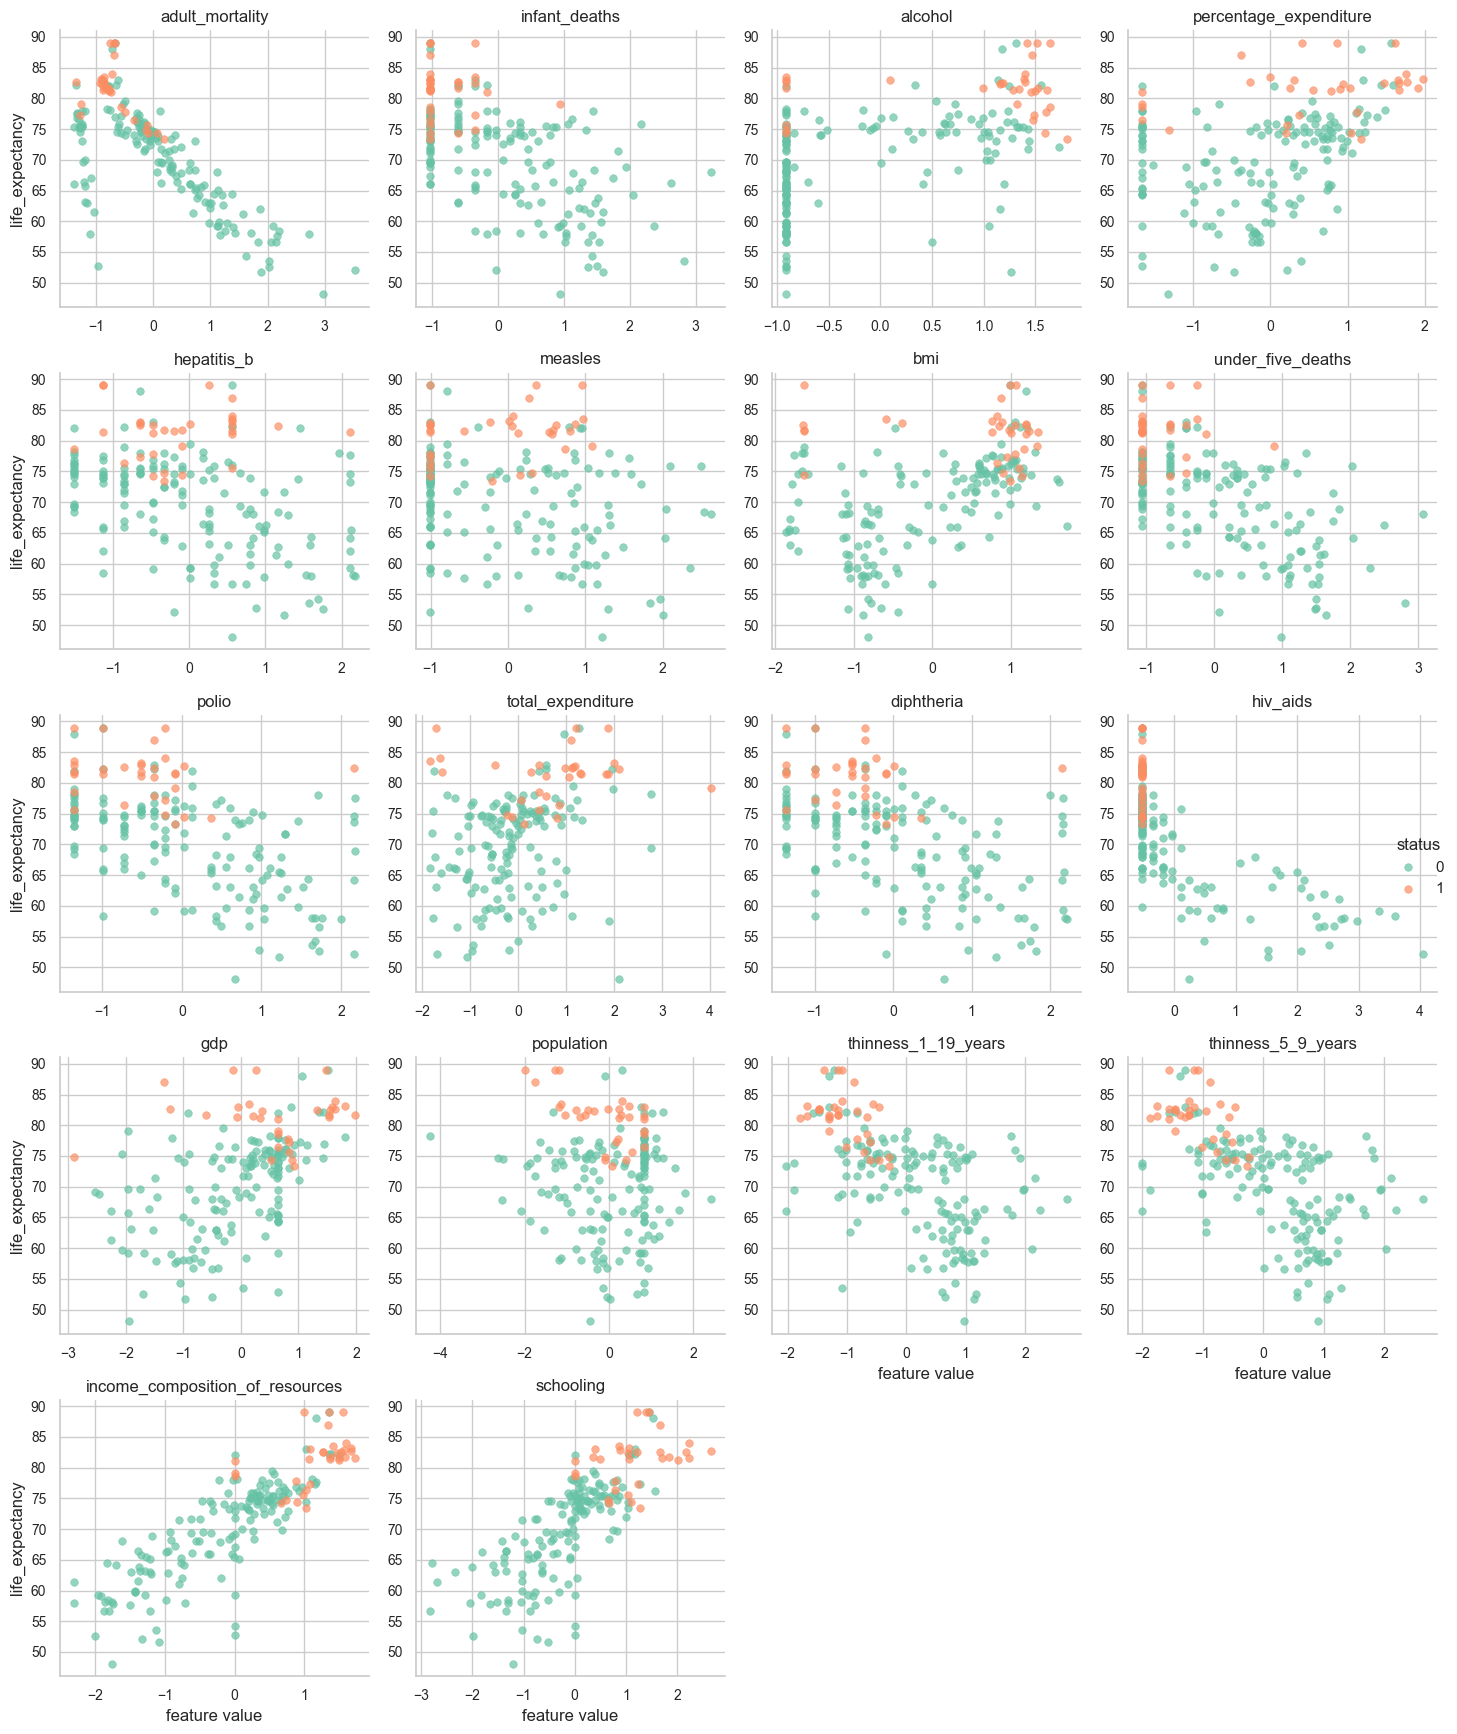

In [16]:
feature_cols = tf_df.columns.tolist()
feature_cols.remove(LECol.YEAR)
plot_scatter_vs_target(
    tf_df,
    feature_cols,
    target=LECol.LIFE_EXPECTANCY.value,
    hue=LECol.STATUS.value,
    wrap=4,
)


## 4. Automatic Feature Grouping Suggestion

Uses correlation structure to suggest feature groups for PCA dimensionality reduction.

In [11]:
from devtools import pprint

corr_mat = (
    LifeExpectancyDataset.from_csv()
    .make_correlation_analyzer(include_target=False)
    .get_correlation_matrix()
)
tresh = 0.8
suggested_groups, summary_df = suggest_groups_from_correlation(
    corr_mat,
    threshold=tresh,
    return_summary=True,
)
pprint(suggested_groups)
summary_df


[
    FeatureGroup(
        name='Group_4',
        features=[
            'diphtheria',
            'hepatitis_b',
        ],
    ),
    FeatureGroup(
        name='Group_8',
        features=[
            'thinness_1_19_years',
            'thinness_5_9_years',
        ],
    ),
    FeatureGroup(
        name='Group_9',
        features=[
            'income_composition_of_resources',
            'schooling',
        ],
    ),
    FeatureGroup(
        name='Group_13',
        features=[
            'infant_deaths',
            'under_five_deaths',
        ],
    ),
]


group  size                                    features  mean_abs_corr  \
0  Group_13     2            infant_deaths, under_five_deaths       0.994196   
1   Group_4     2                     diphtheria, hepatitis_b       0.909236   
2   Group_8     2     thinness_1_19_years, thinness_5_9_years       0.973195   
3   Group_9     2  income_composition_of_resources, schooling       0.917514   

   min_abs_corr  
0      0.994196  
1      0.909236  
2      0.973195  
3      0.917514

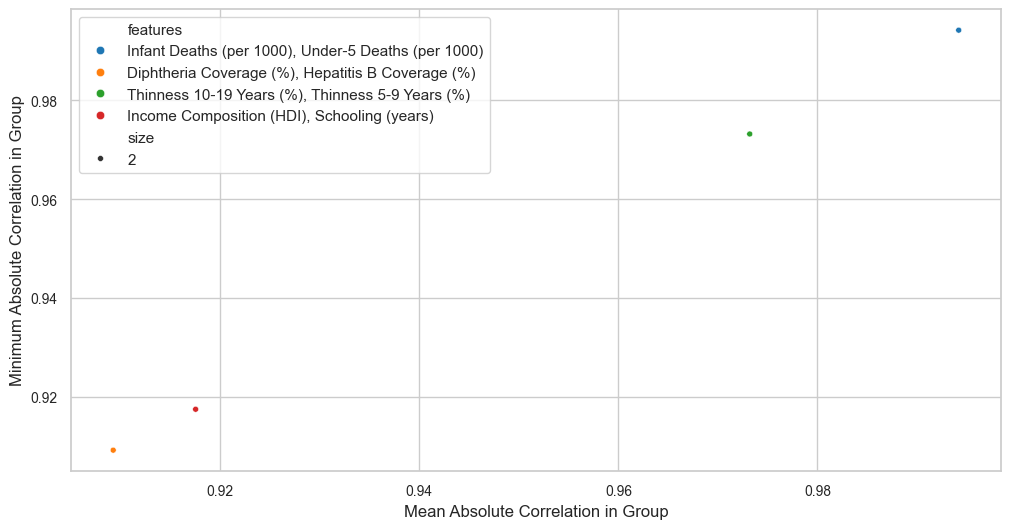

In [12]:
sns.scatterplot(
    data=summary_df.assign(feature_list=summary_df.features.str.split(",")).assign(
        pretty_features=lambda d: d.feature_list.apply(
            lambda lst: [le_ds.get_pretty_name(f.strip()) for f in lst],
        ),
        features=lambda d: d.pretty_features.apply(", ".join),
    ),
    x="mean_abs_corr",
    y="min_abs_corr",
    hue="features",
    size="size",
)
plt.xlabel("Mean Absolute Correlation in Group")
plt.ylabel("Minimum Absolute Correlation in Group")
plt.show()


[
    FeatureGroup(
        name='Group_1',
        features=[
            'diphtheria',
            'hepatitis_b',
            'polio',
        ],
    ),
    FeatureGroup(
        name='Group_4',
        features=[
            'infant_deaths',
            'under_five_deaths',
        ],
    ),
    FeatureGroup(
        name='Group_6',
        features=[
            'income_composition_of_resources',
            'schooling',
        ],
    ),
    FeatureGroup(
        name='Group_9',
        features=[
            'thinness_1_19_years',
            'thinness_5_9_years',
        ],
    ),
]


group  size                                    features  mean_abs_corr  \
0  Group_1     3              diphtheria, hepatitis_b, polio       0.855772   
1  Group_4     2            infant_deaths, under_five_deaths       0.996053   
2  Group_6     2  income_composition_of_resources, schooling       0.913211   
3  Group_9     2     thinness_1_19_years, thinness_5_9_years       0.943641   

   min_abs_corr  
0      0.797389  
1      0.996053  
2      0.913211  
3      0.943641

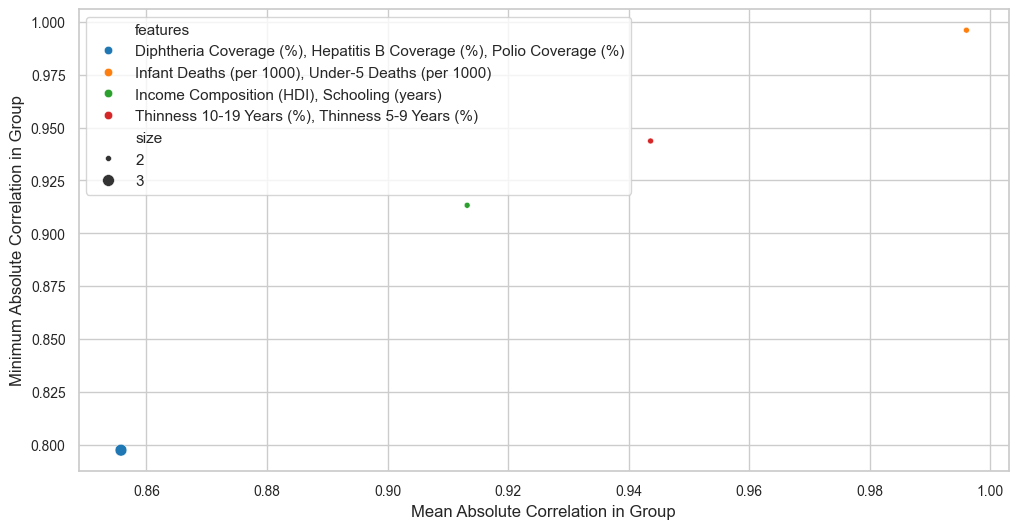

In [13]:
corr_mat = (
    LifeExpectancyDataset(df=tf_df)
    .make_correlation_analyzer(include_target=False)
    .get_correlation_matrix()
)
tresh = 0.8
suggested_groups, summary_df = suggest_groups_from_correlation(
    corr_mat,
    threshold=tresh,
    return_summary=True,
)
pprint(suggested_groups)
display(summary_df)

sns.scatterplot(
    data=summary_df.assign(feature_list=summary_df.features.str.split(",")).assign(
        pretty_features=lambda d: d.feature_list.apply(
            lambda lst: [le_ds.get_pretty_name(f.strip()) for f in lst],
        ),
        features=lambda d: d.pretty_features.apply(", ".join),
    ),
    x="mean_abs_corr",
    y="min_abs_corr",
    hue="features",
    size="size",
)
plt.xlabel("Mean Absolute Correlation in Group")
plt.ylabel("Minimum Absolute Correlation in Group")
plt.show()


## 5. Inversion of Immunization Coverage

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_37218/873617891.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


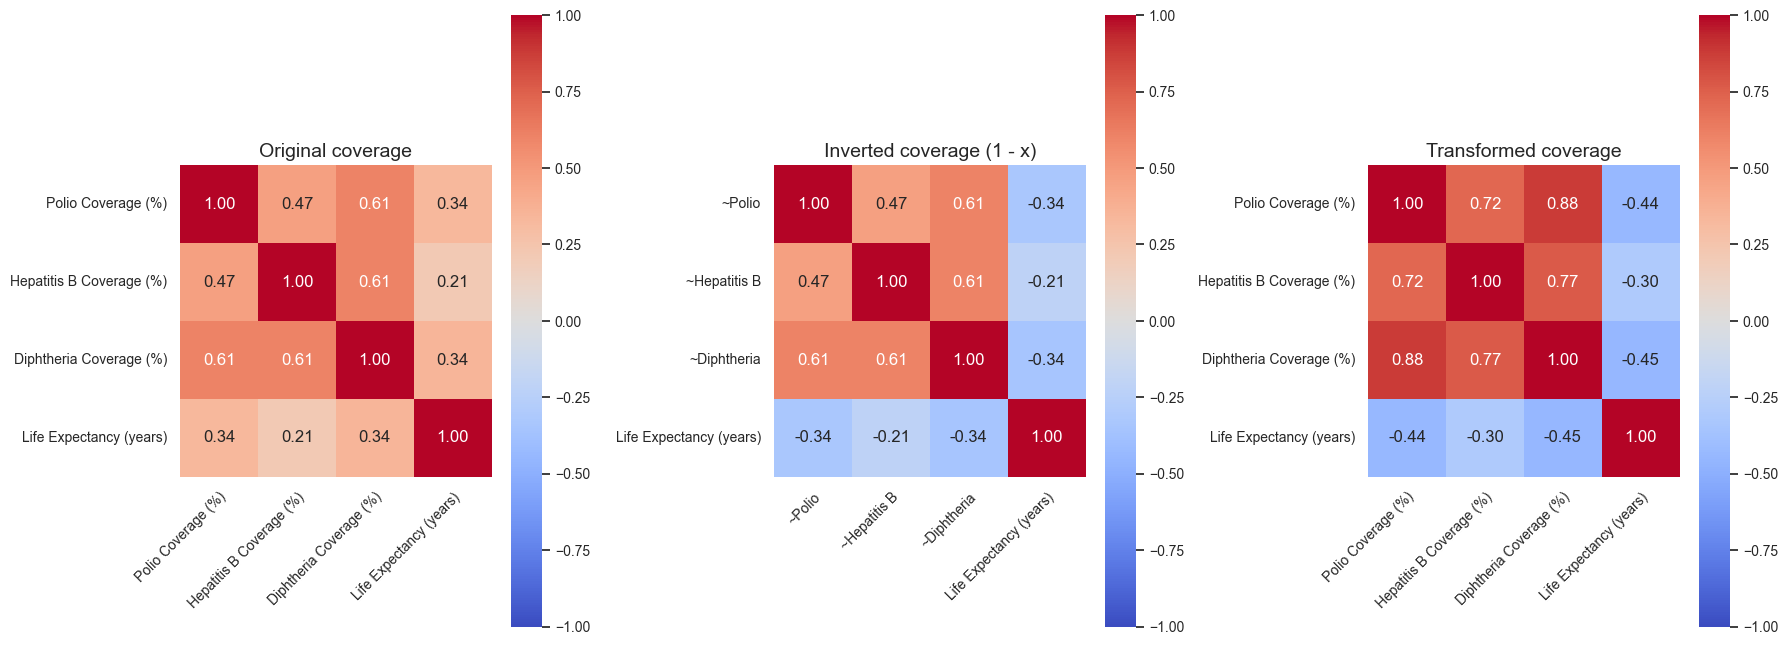

In [18]:
cov_cols = [LECol.POLIO, LECol.HEPATITIS_B, LECol.DIPHTHERIA]

df = le_ds.df.copy()
inv_cov_cols = [f"~{c}" for c in cov_cols]

base_corr = (
    le_ds.make_correlation_analyzer(
        columns=[*cov_cols, LECol.TARGET],
        include_target=True,
    )
    .fit()
    .result()
)
inv_corr = (
    df.assign(**{col: 1 - df[col] for col in cov_cols})
    .rename(columns={c: f"~{c}" for c in cov_cols})
    .pipe(LifeExpectancyDataset)
    .make_correlation_analyzer(
        columns=[*inv_cov_cols, LECol.TARGET],
        include_target=True,
    )
    .fit()
    .result()
)

inv_tf_corr = (
    le_ds.tf_and_norm()
    .pipe(LifeExpectancyDataset)
    .make_correlation_analyzer(
        columns=[*cov_cols, LECol.TARGET],
        include_target=True,
    )
    .fit()
    .result()
)

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
base_corr.plot_heatmap(ax=axes[0])
axes[0].set_title("Original coverage")
inv_corr.plot_heatmap(ax=axes[1])
axes[1].set_title("Inverted coverage (1 - x)")
inv_tf_corr.plot_heatmap(ax=axes[2])
axes[2].set_title("Transformed coverage")
fig.show()
